In [1]:
import numpy as np
import pandas as pd
import urllib
import geopandas as gpd
import matplotlib.image as mpimg
%matplotlib inline
import seaborn as sns
from shapely.geometry import Point
import warnings
import folium
from folium.plugins import HeatMap
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
import xgboost as xgb
import statsmodels.formula.api as smf
from matplotlib.colors import Normalize
from matplotlib.colorbar import ColorbarBase
from matplotlib.cm import ScalarMappable, viridis
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

warnings.filterwarnings('ignore')

D:\anaconda\envs\cusp\Lib\site-packages\geopandas\_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


In [2]:
# Read data
airbnb = pd.read_csv("Airbnb_NYC_2023_11.csv")
airbnb.head()

id                                               name  host_id  \
0   2595  Rental unit in New York · ★4.68 · Studio · 1 b...     2845   
1   5121  Rental unit in Brooklyn · ★4.52 · 1 bedroom · ...     7356   
2   9357  Rental unit in New York · ★4.52 · Studio · 1 b...    30193   
3   6848  Rental unit in Brooklyn · ★4.58 · 2 bedrooms ·...    15991   
4  10452  Rental unit in Brooklyn · ★4.65 · 1 bedroom · ...    35935   

       host_name neighbourhood_group       neighbourhood  latitude  longitude  \
0       Jennifer           Manhattan             Midtown  40.75356  -73.98559   
1          Garon            Brooklyn  Bedford-Stuyvesant  40.68535  -73.95512   
2          Tommi           Manhattan      Hell's Kitchen  40.76724  -73.98664   
3  Allen & Irina            Brooklyn        Williamsburg  40.70935  -73.95342   
4         Angela            Brooklyn  Bedford-Stuyvesant  40.68294  -73.95682   

         room_type  price  minimum_nights  number_of_reviews last_review  \
0  Entire home/apt    240              30                 49  2022-06-21   
1     Private room     66              30                 50  2019-12-02   
2  Entire home/apt    175              45                 58  2017-08-13   
3  Entire home/apt     81              30                191  2023-08-14   
4     Private room     90              30                 80  2023-09-16   

   reviews_per_month  calculated_host_listings_count  availability_365  \
0               0.29                               3               365   
1               0.28                               2               120   
2               0.34                               1               340   
3               1.09                               1               110   
4               0.49                               4               290   

   number_of_reviews_ltm license  
0                      0     NaN  
1                      0     NaN  
2                      0     NaN  
3                      5     NaN  
4                      2     NaN

In [3]:
len(airbnb)

39160

In [4]:
airbnb.dtypes

id                                  int64
name                               object
host_id                             int64
host_name                          object
neighbourhood_group                object
neighbourhood                      object
latitude                          float64
longitude                         float64
room_type                          object
price                               int64
minimum_nights                      int64
number_of_reviews                   int64
last_review                        object
reviews_per_month                 float64
calculated_host_listings_count      int64
availability_365                    int64
number_of_reviews_ltm               int64
license                            object
dtype: object

### 1 - Understand and clean data

In [5]:
# Check for missing values in the Airbnb dataset
airbnb.isnull().sum()

id                                    0
name                                  0
host_id                               0
host_name                             5
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10949
reviews_per_month                 10949
calculated_host_listings_count        0
availability_365                      0
number_of_reviews_ltm                 0
license                           35281
dtype: int64

In [6]:
# Drop Specific Columns
airbnb.drop(['id', 'name', 'host_name', 'last_review', 'license'], axis=1, inplace=True)
airbnb.head()

host_id neighbourhood_group       neighbourhood  latitude  longitude  \
0     2845           Manhattan             Midtown  40.75356  -73.98559   
1     7356            Brooklyn  Bedford-Stuyvesant  40.68535  -73.95512   
2    30193           Manhattan      Hell's Kitchen  40.76724  -73.98664   
3    15991            Brooklyn        Williamsburg  40.70935  -73.95342   
4    35935            Brooklyn  Bedford-Stuyvesant  40.68294  -73.95682   

         room_type  price  minimum_nights  number_of_reviews  \
0  Entire home/apt    240              30                 49   
1     Private room     66              30                 50   
2  Entire home/apt    175              45                 58   
3  Entire home/apt     81              30                191   
4     Private room     90              30                 80   

   reviews_per_month  calculated_host_listings_count  availability_365  \
0               0.29                               3               365   
1               0.28                               2               120   
2               0.34                               1               340   
3               1.09                               1               110   
4               0.49                               4               290   

   number_of_reviews_ltm  
0                      0  
1                      0  
2                      0  
3                      5  
4                      2

In [7]:
# Fill Missing Values in a Specific Column
airbnb.fillna({'reviews_per_month': 0}, inplace=True)
airbnb.reviews_per_month.isnull().sum()

0

In [8]:
# Retrieve unique values from the 'neighbourhood_group' column
airbnb.neighbourhood_group.unique()

array(['Manhattan', 'Brooklyn', 'Queens', 'Bronx', 'Staten Island'],
      dtype=object)

In [9]:
# Calculate the number of unique neighborhoods
len(airbnb.neighbourhood.unique())

223

In [10]:
# Generate descriptive statistics
airbnb.describe()

host_id      latitude     longitude         price  minimum_nights  \
count  3.916000e+04  39160.000000  39160.000000  39160.000000    39160.000000   
mean   1.575643e+08     40.729372    -73.945897    205.995480       30.272165   
std    1.693066e+08      0.056645      0.054958    466.662167       26.534306   
min    1.678000e+03     40.500314    -74.251907      0.000000        1.000000   
25%    1.654341e+07     40.688880    -73.982819     76.000000       30.000000   
50%    7.831966e+07     40.726470    -73.953960    130.000000       30.000000   
75%    2.783108e+08     40.762632    -73.926260    220.000000       30.000000   
max    5.442621e+08     40.911380    -73.713650  30000.000000     1250.000000   

       number_of_reviews  reviews_per_month  calculated_host_listings_count  \
count       39160.000000       39160.000000                    39160.000000   
mean           25.584397           0.770732                       39.493105   
std            57.488642           1.545545                      117.040976   
min             0.000000           0.000000                        1.000000   
25%             0.000000           0.000000                        1.000000   
50%             4.000000           0.160000                        1.000000   
75%            23.000000           0.930000                        6.000000   
max          1854.000000          73.720000                      647.000000   

       availability_365  number_of_reviews_ltm  
count      39160.000000           39160.000000  
mean         153.915628               6.735674  
std          144.305706              17.023977  
min            0.000000               0.000000  
25%            0.000000               0.000000  
50%          130.000000               0.000000  
75%          309.000000               5.000000  
max          365.000000             900.000000

### Load ZIPCODE Dataset and Add Zipcode

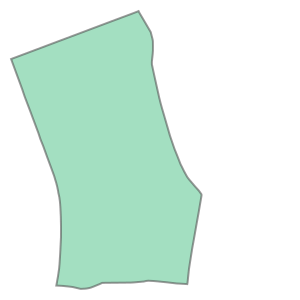

In [11]:
zipcode = gpd.read_file('./ZIPCODE/ZIP_CODE_040114.shp')
zipcode['geometry'][0]

In [12]:
# Convert the DataFrame to a GeoDataFrame with geographic coordinates
airbnb_gdf = gpd.GeoDataFrame(
    airbnb,
    geometry=gpd.points_from_xy(airbnb.longitude, airbnb.latitude),
    crs="EPSG:4326"
)

In [13]:
# Transform the coordinate reference system of the Airbnb GeoDataFrame to match that of the zipcode GeoDataFrame
airbnb_gdf = airbnb_gdf.to_crs(zipcode.crs)

In [14]:
# Perform a spatial join between the Airbnb and zipcode GeoDataFrames
joined_gdf = gpd.sjoin(airbnb_gdf, zipcode, how="left", op="within")
joined_gdf['ZIPCODE']

0        10018
1        11216
2        10019
3        11211
4        11238
         ...  
39155    10001
39156    11221
39157    10016
39158    10016
39159    10016
Name: ZIPCODE, Length: 39250, dtype: object

In [15]:
unique_zipcodes = joined_gdf.reset_index().groupby('index').first()
airbnb_with_zip = airbnb.merge(unique_zipcodes[['ZIPCODE']], left_index=True, right_index=True, how='left')
len(airbnb_with_zip)

39160

In [16]:
airbnb_with_zip

host_id neighbourhood_group       neighbourhood   latitude  \
0           2845           Manhattan             Midtown  40.753560   
1           7356            Brooklyn  Bedford-Stuyvesant  40.685350   
2          30193           Manhattan      Hell's Kitchen  40.767240   
3          15991            Brooklyn        Williamsburg  40.709350   
4          35935            Brooklyn  Bedford-Stuyvesant  40.682940   
...          ...                 ...                 ...        ...   
39155  401202937           Manhattan             Midtown  40.747829   
39156  441448134            Brooklyn  Bedford-Stuyvesant  40.689207   
39157  107434423           Manhattan            Kips Bay  40.744972   
39158  107434423           Manhattan            Kips Bay  40.740508   
39159  107434423           Manhattan            Kips Bay  40.739918   

       longitude        room_type  price  minimum_nights  number_of_reviews  \
0     -73.985590  Entire home/apt    240              30                 49   
1     -73.955120     Private room     66              30                 50   
2     -73.986640  Entire home/apt    175              45                 58   
3     -73.953420  Entire home/apt     81              30                191   
4     -73.956820     Private room     90              30                 80   
...          ...              ...    ...             ...                ...   
39155 -73.986907     Private room     64               1                  0   
39156 -73.936728  Entire home/apt    119              30                  0   
39157 -73.977042  Entire home/apt    266              31                  0   
39158 -73.978347  Entire home/apt    322              31                  0   
39159 -73.978986  Entire home/apt    233              31                  0   

       reviews_per_month  calculated_host_listings_count  availability_365  \
0                   0.29                               3               365   
1                   0.28                               2               120   
2                   0.34                               1               340   
3                   1.09                               1               110   
4                   0.49                               4               290   
...                  ...                             ...               ...   
39155               0.00                              56                62   
39156               0.00                               1               258   
39157               0.00                             647               333   
39158               0.00                             647               365   
39159               0.00                             647               365   

       number_of_reviews_ltm ZIPCODE  
0                          0   10018  
1                          0   11216  
2                          0   10019  
3                          5   11211  
4                          2   11238  
...                      ...     ...  
39155                      0   10001  
39156                      0   11221  
39157                      0   10016  
39158                      0   10016  
39159                      0   10016  

[39160 rows x 14 columns]

### 2 - Exploring and Visualizing Data

In [17]:
# Identify the top 10 hosts with the most listings in the Airbnb dataset
top_host = airbnb.host_id.value_counts().head(10)
top_host

host_id
107434423    647
3223938      542
305240193    372
496944100    304
19303369     262
200239515    242
204704622    228
162280872    227
501999278    183
501499086    149
Name: count, dtype: int64

In [18]:
# Find the maximum number of listings for any single host in the Airbnb dataset
top_host_check = airbnb.calculated_host_listings_count.max()
top_host_check

647

Text(0.5, 1.0, 'Top 5 Hosts With Most Posts')

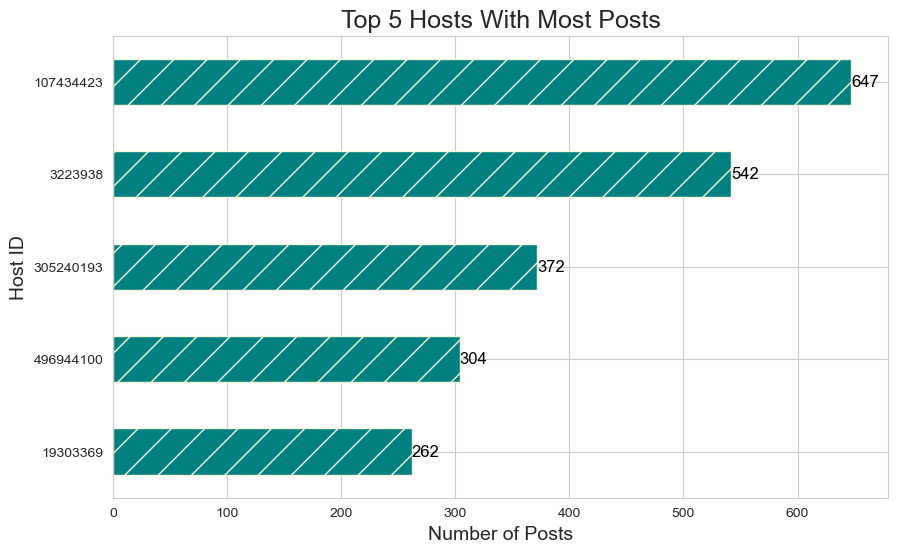

In [19]:
# Setting the Plot Style:
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))
ax = plt.axes()
# Plotting the Data:
airbnb["host_id"].value_counts().head().sort_values().plot(kind="barh",
                                                           color="teal", hatch="/", edgecolor="beige")
# Adding Labels to Bars:
ax.bar_label(ax.containers[0], fmt='%.0f', color="black", fontsize=12)
# Setting X and Y Axes Labels:
plt.xlabel("Number of Posts", size=14)
plt.ylabel("Host ID", size=14)
plt.title("Top 5 Hosts With Most Posts", size=18)

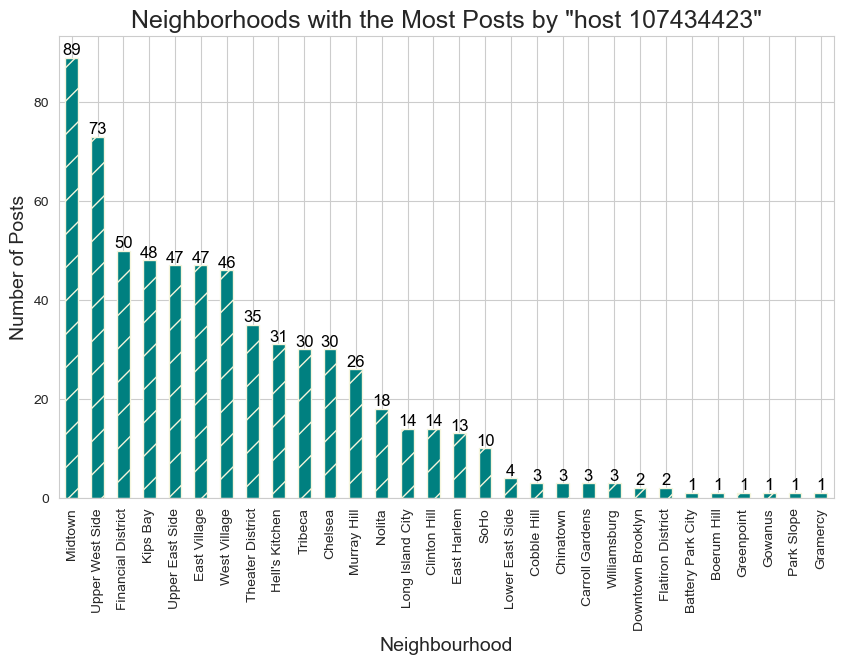

In [20]:
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))
ax = plt.axes()
# Plotting the Data:
airbnb.loc[airbnb['host_id'] == 107434423]["neighbourhood"].value_counts().plot(kind="bar", color="teal", hatch="/",
                                                                                edgecolor="beige")
# Adding Labels to Bars:
ax.bar_label(ax.containers[0], fmt='%.0f', color="black", fontsize=12)
plt.xlabel("Neighbourhood", size=14)
plt.ylabel("Number of Posts", size=14)
plt.title('Neighborhoods with the Most Posts by "host 107434423"', size=18)
plt.show()

Text(0.5, 1.0, 'Neighbourhood Groups')

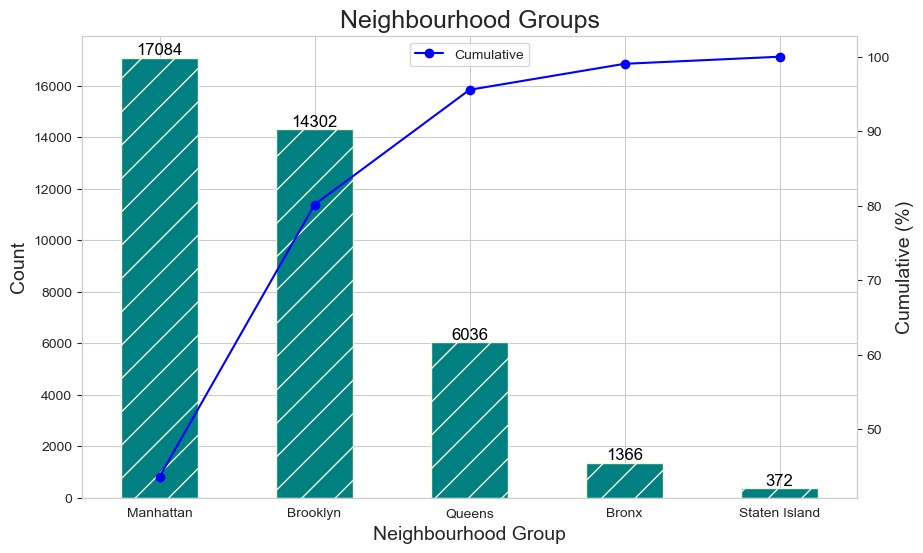

In [21]:
# Calculate Cumulative Percentage:
cumulative = round(airbnb["neighbourhood_group"].value_counts(normalize=True).cumsum() * 100, 2)
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))
# Create Bar Chart:
ax1 = airbnb["neighbourhood_group"].value_counts().sort_values(ascending=False).plot(kind="bar", color="teal",
                                                                                     hatch="/", edgecolor="beige")
ax1.bar_label(ax1.containers[0], fmt='%.0f', color="black", fontsize=12)
# Create Line Chart:
ax2 = cumulative.plot(kind="line", color="blue", secondary_y=True, marker="o")
ax1.set_xlabel("Neighbourhood Group", size=14)
ax1.set_ylabel("Count", size=14)
ax2.set_ylabel("Cumulative (%)", size=14)
ax2.legend(["Cumulative"], loc=9)
plt.title("Neighbourhood Groups", size=18)

In [22]:
# Filter the Airbnb dataset to include only listings with a price greater than 0
airbnb = airbnb.loc[airbnb['price'] > 0]
# Find the minimum price among the filtered listings
airbnb['price'].min()

10

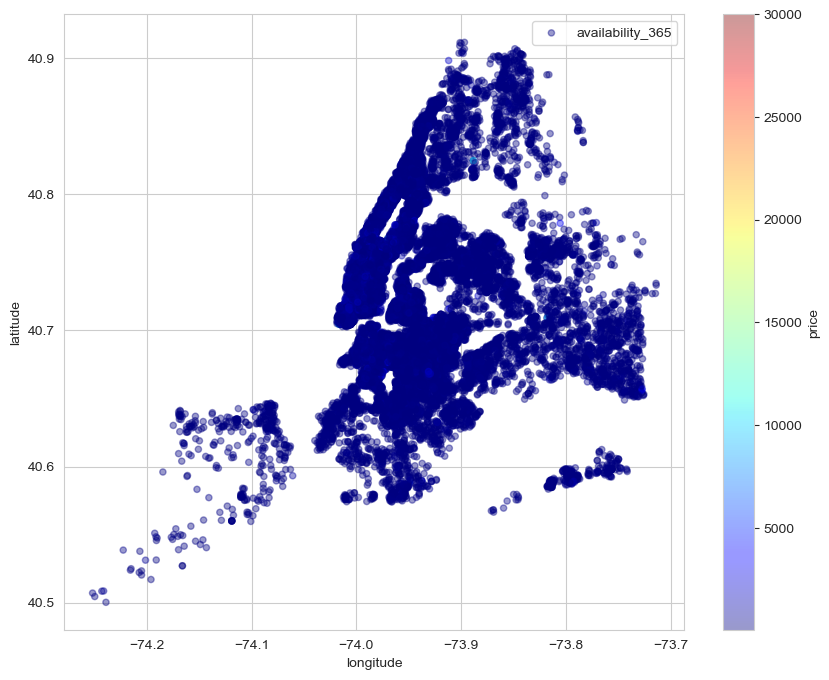

In [23]:
# Create a scatter plot of Airbnb listings with price-based coloring
airbnb_geo = airbnb.plot(kind='scatter', x='longitude', y='latitude', label='availability_365', c='price',
                         cmap=plt.get_cmap('jet'), colorbar=True, alpha=0.4, figsize=(10, 8))
airbnb_geo.legend()

In [24]:
#Brooklyn
sub_1 = airbnb.loc[airbnb['neighbourhood_group'] == 'Brooklyn']
price_sub1 = sub_1[['price']]
#Manhattan
sub_2 = airbnb.loc[airbnb['neighbourhood_group'] == 'Manhattan']
price_sub2 = sub_2[['price']]
#Queens
sub_3 = airbnb.loc[airbnb['neighbourhood_group'] == 'Queens']
price_sub3 = sub_3[['price']]
#Staten Island
sub_4 = airbnb.loc[airbnb['neighbourhood_group'] == 'Staten Island']
price_sub4 = sub_4[['price']]
#Bronx
sub_5 = airbnb.loc[airbnb['neighbourhood_group'] == 'Bronx']
price_sub5 = sub_5[['price']]

price_list_by_n = [price_sub1, price_sub2, price_sub3, price_sub4, price_sub5]

In [25]:
data1 = []

city_list = ['Brooklyn', 'Manhattan', 'Queens', 'Staten Island', 'Bronx']

for x in price_list_by_n:
    i = x.describe(percentiles=[.25, .50, .75])
    i = i.iloc[3:]
    i.reset_index(inplace=True)
    i.rename(columns={'index': 'Stats'}, inplace=True)
    data1.append(i)

data1[0].rename(columns={'price': city_list[0]}, inplace=True)
data1[1].rename(columns={'price': city_list[1]}, inplace=True)
data1[2].rename(columns={'price': city_list[2]}, inplace=True)
data1[3].rename(columns={'price': city_list[3]}, inplace=True)
data1[4].rename(columns={'price': city_list[4]}, inplace=True)

stat_df = data1
stat_df = [df.set_index('Stats') for df in stat_df]
stat_df = stat_df[0].join(stat_df[1:])
stat_df

Brooklyn  Manhattan   Queens  Staten Island   Bronx
Stats                                                     
min        10.0       10.0     10.0           33.0    10.0
25%        65.0      108.0     55.0           70.0    60.0
50%       110.0      175.0     90.0           99.0    90.0
75%       185.0      290.0    147.0          142.0   141.0
max      7500.0    30000.0  10000.0         1200.0  9994.0

In [26]:
sub_6 = airbnb[airbnb.price < 500]

Text(0.5, 1.0, 'Density and distribution of prices for each neighberhood_group')

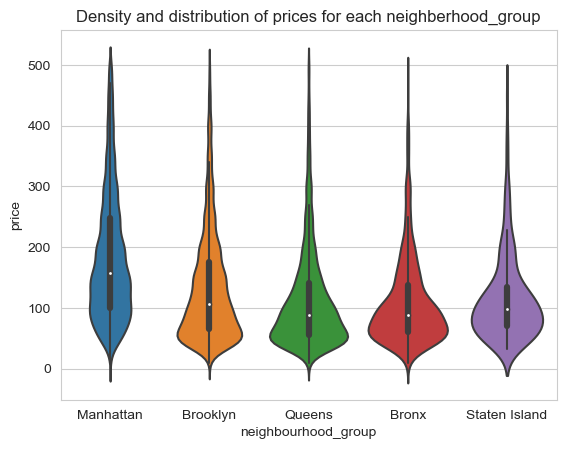

In [27]:
# Create a violin plot for price distribution across different neighbourhood groups
data2 = sns.violinplot(data=sub_6, x='neighbourhood_group', y='price')
# Set the title of the violin plot
data2.set_title('Density and distribution of prices for each neighberhood_group')

In [28]:
airbnb.neighbourhood.value_counts().head(10)

neighbourhood
Bedford-Stuyvesant    2723
Williamsburg          2296
Midtown               2076
Harlem                1841
Bushwick              1641
Hell's Kitchen        1599
Upper East Side       1533
Upper West Side       1517
Crown Heights         1235
East Village          1070
Name: count, dtype: int64

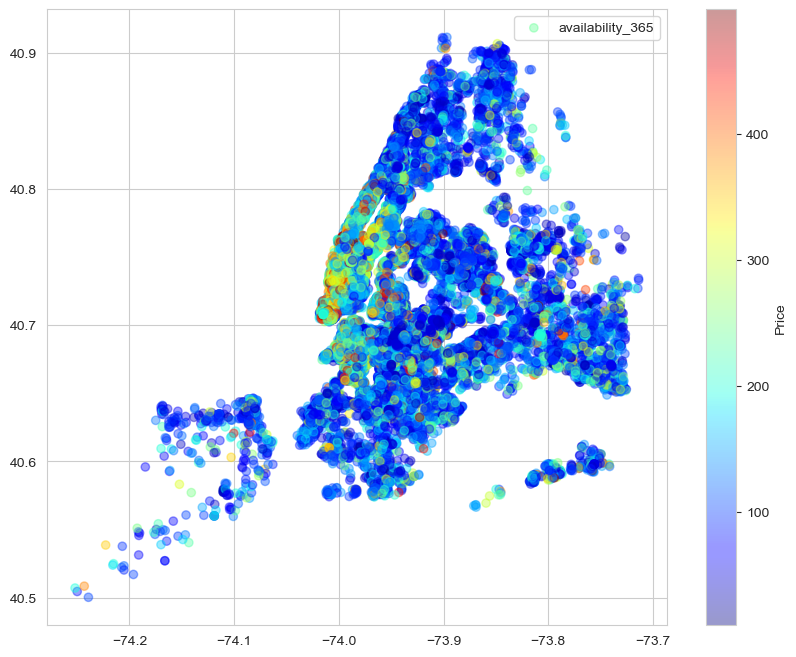

In [29]:
# Convert a subset of the Airbnb data into a GeoDataFrame for geographic plotting
gdf = gpd.GeoDataFrame(sub_6, geometry=gpd.points_from_xy(sub_6.longitude, sub_6.latitude))

# Create a scatter plot of the GeoDataFrame
fig, ax = plt.subplots(figsize=(10, 8))
scatter = ax.scatter(gdf.geometry.x, gdf.geometry.y, c=gdf['price'], cmap='jet', alpha=0.4)

plt.colorbar(scatter, ax=ax, label='Price')
ax.legend(['availability_365'])
plt.show()

In [30]:
# Initialize a Folium map centered at New York City's coordinates
m = folium.Map([40.7128, -74.0060], zoom_start=11)
# Create and add a HeatMap layer to the map
# This uses the latitude and longitude from the Airbnb dataset
# `dropna()` removes any rows with missing values in these columns
# `radius` sets the size of each point in the heat map
# `gradient` defines the color scheme based on the density of points
HeatMap(airbnb[['latitude', 'longitude']].dropna(), radius=8,
        gradient={0.2: 'blue', 0.4: 'purple', 0.6: 'orange', 1.0: 'red'}).add_to(m)
display(m)

Text(0.5, 1.0, 'Price Distribution After Log Transformation')

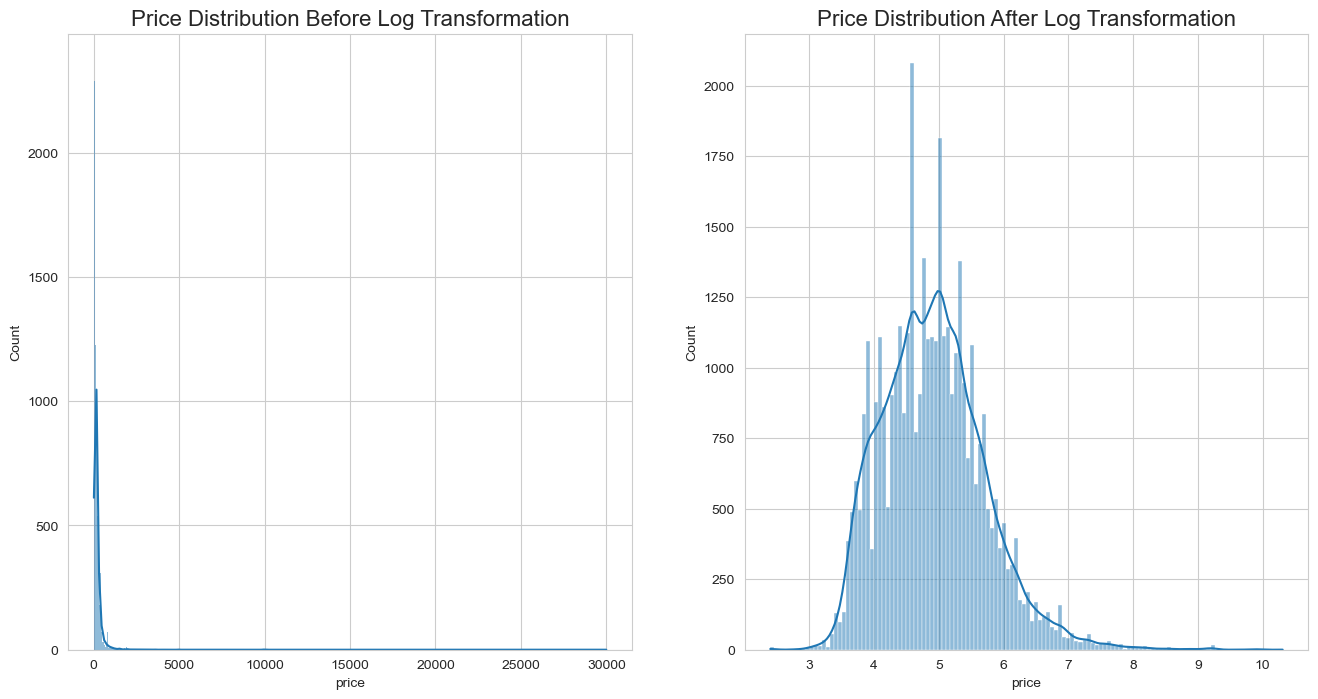

In [31]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
# First subplot: Histogram of the original price distribution with Kernel Density Estimate (KDE)
sns.histplot(data=airbnb, x="price", kde=True, ax=ax[0]).set_title("Price Distribution Before Log Transformation",
                                                                   size=16)

# Second subplot: Histogram of the price distribution after applying logarithmic transformation
sns.histplot(np.log1p(airbnb.price), kde=True, ax=ax[1]).set_title("Price Distribution After Log Transformation",
                                                                   size=16)

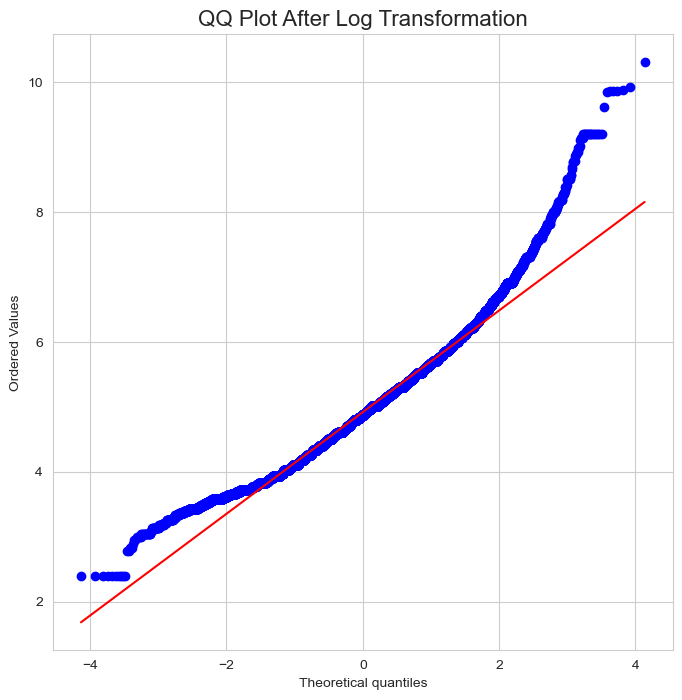

In [32]:
# Apply a logarithmic transformation to the 'price' column
price_after_transform = np.log1p(airbnb["price"])
plt.figure(figsize=(8, 8))
# Generate a QQ plot to assess the normality of the log-transformed prices
stats.probplot(price_after_transform, plot=plt)
plt.title("QQ Plot After Log Transformation", size=16)
plt.show()

In [33]:
geojs = gpd.read_file('neighborhood.geojson')

In [34]:
df = airbnb[['latitude', 'longitude', 'price']]

In [35]:
df['coords'] = list(zip(df.longitude, df.latitude))
df['coords'] = df['coords'].apply(Point)

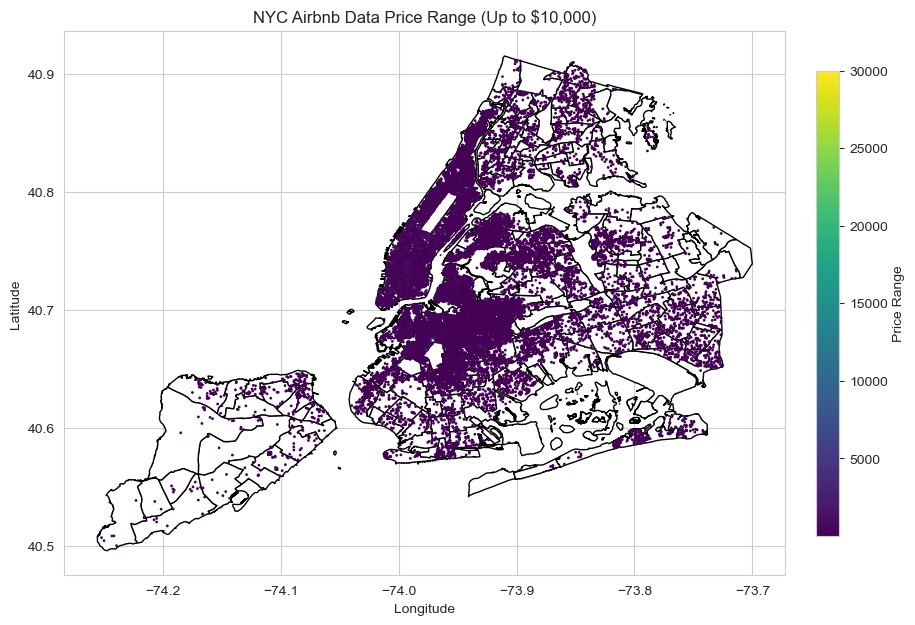

In [36]:
gdf = gpd.GeoDataFrame(df, geometry='coords')
# Create a base map using the 'geojs' GeoDataFrame
base = geojs.plot(color='white', edgecolor='black', linewidth=1, figsize=(10, 10))
# Normalize the color range for the price data
norm = Normalize(vmin=gdf['price'].min(), vmax=gdf['price'].max())
# Plot the data on the base map using price as the color determinant
price_plot = gdf.plot(ax=base, marker='o', column='price', markersize=1, cmap='viridis', legend=False, norm=norm)

sm = ScalarMappable(norm=norm, cmap='viridis')
sm._A = []
cbar = plt.colorbar(sm, ax=base, fraction=0.03, pad=0.04)
cbar.set_label('Price Range')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('NYC Airbnb Data Price Range (Up to $10,000)')
plt.savefig('Price_map.svg', bbox_inches='tight')

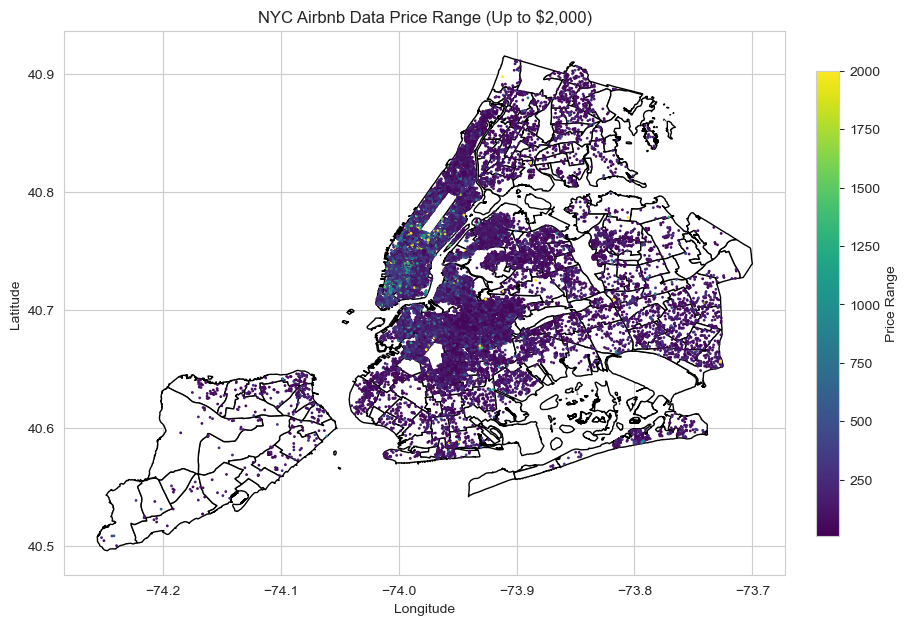

In [37]:
gdf = gpd.GeoDataFrame(df, geometry='coords')
# Plot a base map using the 'geojs' GeoDataFrame, with white color and black edges
base = geojs.plot(color='white', edgecolor='black', linewidth=1, figsize=(10, 10))
# Normalize the color range for the price data with a maximum 2000
norm = Normalize(vmin=gdf['price'].min(), vmax=2000)

price_plot = gdf.plot(ax=base, marker='o', column='price', markersize=1, cmap='viridis', legend=False, norm=norm)
# Create a ScalarMappable for the color bar, using the 'viridis' colormap and the normalization
sm = ScalarMappable(norm=norm, cmap='viridis')
sm._A = []
cbar = plt.colorbar(sm, ax=base, fraction=0.03, pad=0.04)
cbar.set_label('Price Range')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('NYC Airbnb Data Price Range (Up to $2,000)')
plt.savefig('Price_map.svg', bbox_inches='tight')

In [38]:
Rental_Income = pd.read_csv("DOF_Condominium_Comparable_Rental_Income_in_NYC_20231211.csv")
Rental_Income

Boro-Block-Lot Condo Section                Address  \
0       1-00576-7501       0003-R1      60 WEST 13 STREET   
1       1-01271-7501       0007-R2          1360 6 AVENUE   
2       1-00894-7501       0009-R1         77 PARK AVENUE   
3       1-00631-7501       0018-R1   712 GREENWICH STREET   
4       1-00868-7501       0019-R1      35 EAST 38 STREET   
...              ...           ...                    ...   
31570   5-02829-7501       0100-R1     31 HYLAN BOULEVARD   
31571   5-02862-7501       0086-R1         50 BELAIR ROAD   
31572   5-03019-7501       0117-R1  81 NARROWS ROAD NORTH   
31573   5-03318-7501       0097-R1    163 CROMWELL AVENUE   
31574   5-05491-7501       0012-R1   119 CORTELYOU AVENUE   

                    Neighborhood Building Classification  Total Units  \
0      GREENWICH VILLAGE-CENTRAL           R4  -ELEVATOR           70   
1                   MIDTOWN WEST           R4  -ELEVATOR          183   
2                    MURRAY HILL           R4  -ELEVATOR          109   
3         GREENWICH VILLAGE-WEST            R9  -CONDOPS           20   
4                    MURRAY HILL           R4  -ELEVATOR          113   
...                          ...                     ...          ...   
31570                   ROSEBANK         R4    -ELEVATOR           52   
31571                   ROSEBANK          R2    -WALK-UP           48   
31572                   ROSEBANK          R2    -WALK-UP           40   
31573               DONGAN HILLS          R2    -WALK-UP           48   
31574                GREAT KILLS          R2    -WALK-UP          165   

       Year Built  Gross SqFt  Estimated Gross Income  Gross Income per SqFt  \
0          1966.0       82017                 4452703                  54.29   
1          1963.0      141738                 7113830                  50.19   
2          1924.0      158571                 7329152                  46.22   
3          1910.0       53943                 2132906                  39.54   
4          1961.0       88230                 4288860                  48.61   
...           ...         ...                     ...                    ...   
31570      1988.0       63601                 1425934                  22.42   
31571      1985.0       51425                 1097410                  21.34   
31572      1946.0       38700                  846369                  21.87   
31573      1973.0       38424                  745810                  19.41   
31574      1974.0      124516                 2584952                  20.76   

       ...  Gross SqFt 3  Estimated Gross Income 3  Gross Income per SqFt 3  \
0      ...       27108.0                 1471693.0                    54.29   
1      ...       39510.0                 1987748.0                    50.31   
2      ...       20784.0                  960636.0                    46.22   
3      ...       37064.0                 1461804.0                    39.44   
4      ...       41603.0                 2022322.0                    48.61   
...    ...           ...                       ...                      ...   
31570  ...      297600.0                 6743616.0                    22.66   
31571  ...           NaN                       NaN                      NaN   
31572  ...        8950.0                  210862.0                    23.56   
31573  ...       10626.0                  206251.0                    19.41   
31574  ...       69442.0                 1471476.0                    21.19   

       Estimated Expense 3  Expense per SqFt 3 Net Operating Income 3  \
0                 571708.0               21.09               899985.0   
1                 527854.0               13.36              1459894.0   
2                 374112.0               18.00               586524.0   
3                 504070.0               13.60               957734.0   
4                 497572.0               11.96              1524750.0   
...                    ...                 ...  

In [39]:
# Group the Rental Income data by 'Neighborhood' and calculate the average 'Gross Income per SqFt' for each neighborhood
Rental_grossIncome = Rental_Income.groupby(['Neighborhood']).agg({'Gross Income per SqFt': 'mean'})

In [40]:
Rental_grossIncome.sort_index(inplace=True)

In [41]:
Rental_grossIncome.head()

Gross Income per SqFt
Neighborhood                          
15TH Q QUEENS                29.626667
2999                         12.600000
30TH Q BROOKLYN              20.820000
50TH Q BROOKLYN              24.882500
5TH Q BROOKLYN               26.815000

In [42]:
# Group the Airbnb data by 'neighbourhood' and calculate the average 'price' for each neighbourhood
airbnb_neighbor_price = airbnb.groupby(['neighbourhood']).agg({'price': 'mean'})

In [43]:
airbnb_neighbor_price.head()

price
neighbourhood            
Allerton       121.209302
Arden Heights  135.333333
Arrochar       147.500000
Arverne        208.831579
Astoria        113.670330

In [44]:
# Convert the index (neighbourhood names) of the airbnb_neighbor_price DataFrame to uppercase
airbnb_neighbor_price.index = airbnb_neighbor_price.index.str.upper()

In [45]:
filtered_Rental_grossIncome = Rental_grossIncome[Rental_grossIncome.index.isin(airbnb_neighbor_price.index)]

In [46]:
filtered_Rental_grossIncome.head()

Gross Income per SqFt
Neighborhood                       
ARVERNE                   29.905000
ASTORIA                   27.833360
BATH BEACH                17.751803
BAY RIDGE                 20.267846
BAYSIDE                   23.749327

In [47]:
# Group the Rental Income data by 'Neighborhood' and calculate the average 'Market Value per SqFt' for each neighborhood
Rental_marketvalue = Rental_Income.groupby(['Neighborhood']).agg({'Market Value per SqFt': 'mean'})
filtered_Rental_marketvalue = Rental_marketvalue[Rental_marketvalue.index.isin(airbnb_neighbor_price.index)]

In [48]:
filtered_Rental_marketvalue.head()

Market Value per SqFt
Neighborhood                       
ARVERNE                  137.250000
ASTORIA                  143.843281
BATH BEACH                73.815082
BAY RIDGE                 90.857385
BAYSIDE                  120.646635

In [49]:
# Calculate the natural logarithm of the 'price' values in the 'airbnb_neighbor_price' DataFrame
logairbnbPrice = np.log(airbnb_neighbor_price['price'])

# Calculate the natural logarithm of the 'Market Value per SqFt' values in the 'filtered_Rental_marketvalue' DataFrame
logmarketvalue = np.log(filtered_Rental_marketvalue['Market Value per SqFt'])
dataLog = pd.DataFrame({'logairbnbPrice': logairbnbPrice, 'logmarketvalue': logmarketvalue})
dataLog.dropna().head()

logairbnbPrice  logmarketvalue
ARVERNE           5.341528        4.921804
ASTORIA           4.733302        4.968724
BATH BEACH        5.100707        4.301563
BAY RIDGE         4.713814        4.509291
BAYSIDE           5.013900        4.792866

In [50]:
lmairbnbPrice = smf.ols('logmarketvalue~logairbnbPrice', data=dataLog).fit()
print(lmairbnbPrice.summary())

                            OLS Regression Results                            
Dep. Variable:         logmarketvalue   R-squared:                       0.246
Model:                            OLS   Adj. R-squared:                  0.238
Method:                 Least Squares   F-statistic:                     31.56
Date:                Tue, 12 Dec 2023   Prob (F-statistic):           1.85e-07
Time:                        20:51:43   Log-Likelihood:                -47.299
No. Observations:                  99   AIC:                             98.60
Df Residuals:                      97   BIC:                             103.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          2.2494      0.428      5.

ValueError: x and y must have same first dimension, but have shapes (223,) and (99,)

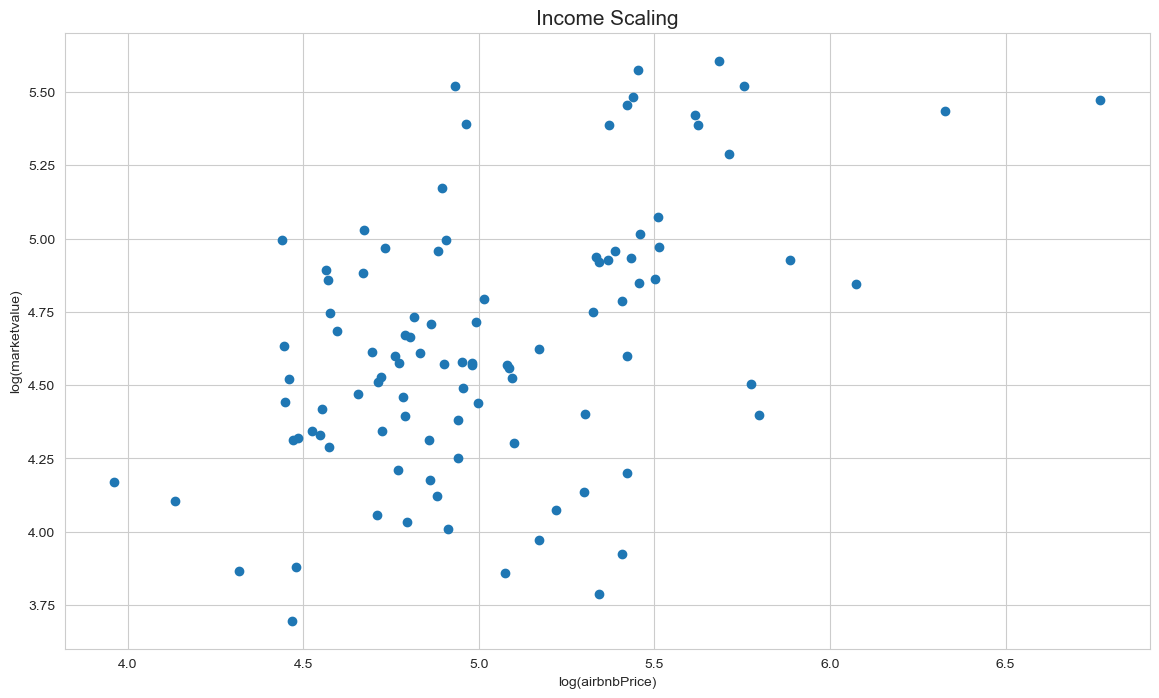

In [51]:
plt.figure(figsize=(14, 8))
plt.plot(dataLog['logairbnbPrice'], dataLog['logmarketvalue'], 'o', label='Data')
plt.title('Income Scaling', fontsize=15)
plt.xlabel('log(airbnbPrice)')
plt.ylabel('log(marketvalue)')
plt.plot(dataLog['logairbnbPrice'], lmairbnbPrice.predict(), '-r', label='Fitted Line')
plt.legend()
plt.show()

In [ ]:
loggrossIncome = np.log(filtered_Rental_grossIncome['Gross Income per SqFt'])

# Create a new DataFrame
dataLog = pd.DataFrame({'logairbnbPrice': logairbnbPrice, 'loggrossIncome': loggrossIncome})

# Drop NaN values and reassign
dataLog = dataLog.dropna()

# Fit the model
lmairbnbPrice = smf.ols('loggrossIncome ~ logairbnbPrice', data=dataLog).fit()

# Plotting
plt.figure(figsize=(14, 8))
plt.plot(dataLog['logairbnbPrice'], dataLog['loggrossIncome'], 'o', label='Data')
plt.title('Income Scaling', fontsize=15)
plt.xlabel('log(airbnbPrice)')
plt.ylabel('log(grossIncome)')
plt.plot(dataLog['logairbnbPrice'], lmairbnbPrice.predict(), '-r', label='Fitted Line')
plt.legend()

plt.show()

### Correlation Matrix

In [ ]:
airbnb.head()

In [52]:
# Initialize LabelEncoder
le = preprocessing.LabelEncoder()

# Encode 'neighbourhood_group' values
le.fit(airbnb['neighbourhood_group'])
airbnb['neighbourhood_group'] = le.transform(airbnb['neighbourhood_group'])

# Encode 'neighbourhood' values
le.fit(airbnb['neighbourhood'])
airbnb['neighbourhood'] = le.transform(airbnb['neighbourhood'])

# Encode 'room_type' values
le.fit(airbnb['room_type'])
airbnb['room_type'] = le.transform(airbnb['room_type'])

In [53]:
airbnb.sort_values('price', ascending=True, inplace=True)

In [54]:
# Apply natural logarithm (log1p) transformation to the 'price' column in the 'airbnb' DataFrame
airbnb["price"] = np.log1p(airbnb["price"])
X = airbnb.drop("price", axis=1)
y = airbnb["price"]
X.head()

host_id  neighbourhood_group  neighbourhood  latitude  longitude  \
28096  306024152                    3            183  40.67144  -73.79488   
20775   24641078                    2            203  40.77723  -73.96053   
11821   67985770                    2            203  40.78140  -73.95058   
20606   33620899                    3            222  40.74909  -73.89678   
15136    1542506                    2             96  40.81766  -73.94472   

       room_type  minimum_nights  number_of_reviews  reviews_per_month  \
28096          2              90                  3               0.21   
20775          0              30                 14               0.46   
11821          0              30                  0               0.00   
20606          0              30                  0               0.00   
15136          2              30                  4               0.08   

       calculated_host_listings_count  availability_365  number_of_reviews_ltm  
28096                               5                 0                      0  
20775                               4                64                      3  
11821                              17                 0                      0  
20606                               1                 0                      0  
15136                               1                 0                      0

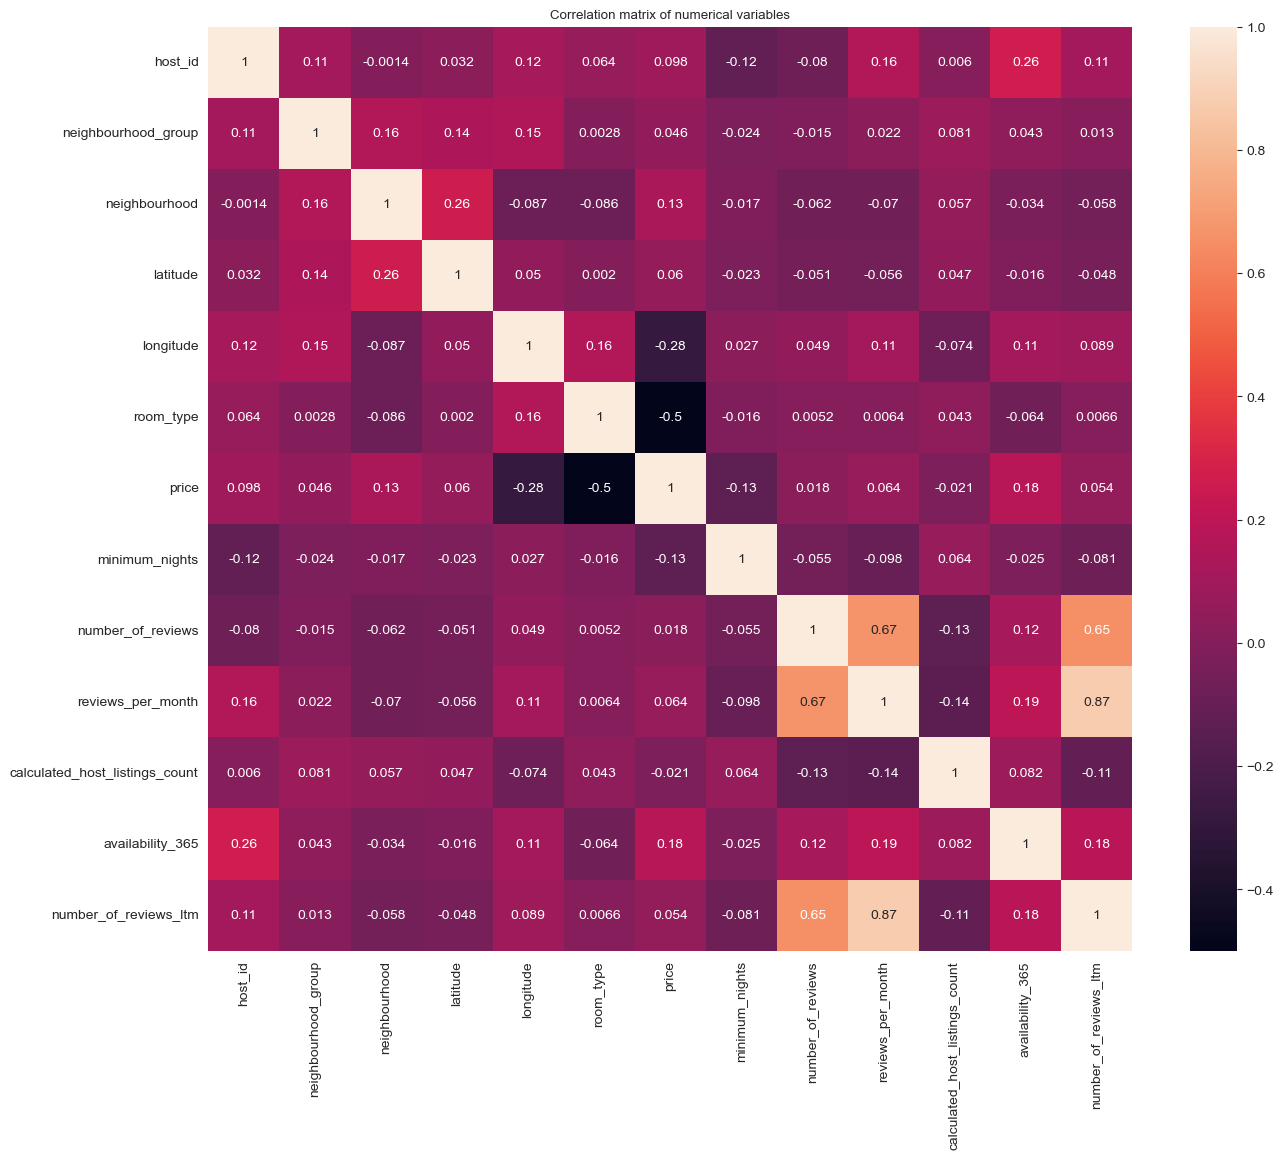

In [55]:
# Calculate the correlation matrix of numerical variables
corrmatrix = airbnb.corr()
title = 'Correlation matrix of numerical variables'
f, ax = plt.subplots(figsize=(15, 12))

# Create a heatmap of the correlation matrix with annotations
sns.heatmap(corrmatrix, square=True, annot=True)
sns.set(font_scale=0.8)
plt.title(title)
plt.show()

In [56]:
# Split the data into a training set (X_train, y_train) and a temporary set (X_temp, y_temp)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)

# Further split the temporary set into a validation set (X_valid, y_valid) and a test set (X_test, y_test)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Reset the index of the training, validation, and test sets
X_train = X_train.reset_index(drop=True)
X_valid = X_valid.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

In [57]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler to the features in the training set
scaler.fit(X_train.iloc[:, 1:])

StandardScaler()

In [58]:
# Transform the training, validation, and test sets using the fitted scaler
X_train_scaled = pd.DataFrame(scaler.transform(X_train.iloc[:, 1:]),
                              columns=X_train.columns[1:],
                              index=X_train.index)
X_valid_scaled = pd.DataFrame(scaler.transform(X_valid.iloc[:, 1:]),
                              columns=X_valid.columns[1:],
                              index=X_valid.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test.iloc[:, 1:]),
                             columns=X_test.columns[1:],
                             index=X_test.index)

In [59]:
#first fit the regression over the training data and report the results
formula = 'price ~ ' + ' + '.join(X_train_scaled.columns)

data = pd.concat([y_train, X_train_scaled], axis=1)
lm = smf.ols(formula=formula, data=data).fit()

print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.5115
Date:                Tue, 12 Dec 2023   Prob (F-statistic):              0.897
Time:                        20:52:34   Log-Likelihood:                -28714.
No. Observations:               25026   AIC:                         5.745e+04
Df Residuals:                   25014   BIC:                         5.755e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

In [60]:
r2_score(y_valid, lm.predict(X_valid_scaled))

-0.00705530198227744

### Linear Regression

In [61]:
# Initialize a Linear Regression model
reg = LinearRegression()

# Fit the model to the scaled training data
reg.fit(X_train_scaled, y_train)

LinearRegression()

In [62]:
reg.coef_

array([ 0.04314847,  0.04652342,  0.04142936, -0.19413443, -0.35124665,
       -0.08960464, -0.0410174 ,  0.07610435, -0.02349796,  0.12945414,
       -0.00473935])

In [63]:
reg.intercept_

4.920723502503638

In [64]:
mean_absolute_error(y_train, reg.predict(X_train_scaled))

0.4681243778605955

In [65]:
mean_squared_error(y_train, reg.predict(X_train_scaled)) ** 0.5

0.6376763777903371

### Decision Tree Regression

In [66]:
# train Decision Tree regression model
decisiontree = DecisionTreeRegressor(max_depth=10, min_samples_split=5)
decisiontree.fit(X_train_scaled, y_train)

#evaluating train error
mean_absolute_error(y_train, decisiontree.predict(X_train_scaled))

0.3411414381087733

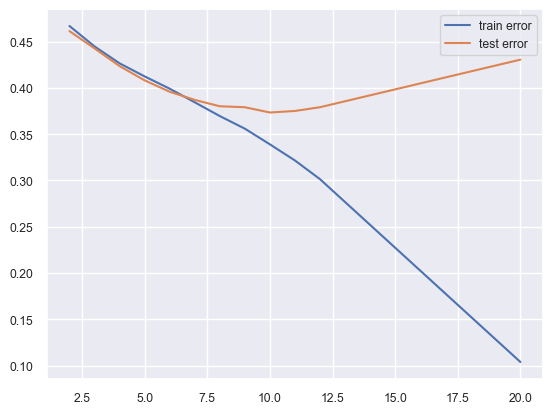

In [67]:
# List of max_depth values to try
max_depth_list = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 20]
train_error = []
test_error = []

# Loop through each max_depth value
for md in max_depth_list:
    # Initialize a DecisionTreeRegressor with the current max_depth
    decisiontree = DecisionTreeRegressor(max_depth=md, min_samples_split=2)

    # Fit the model to the scaled training data
    decisiontree.fit(X_train_scaled, y_train)

    # Calculate and store the mean absolute error on the training set
    train_error.append(mean_absolute_error(y_train, decisiontree.predict(X_train_scaled)))

    # Calculate and store the mean absolute error on the test set
    test_error.append(mean_absolute_error(y_test, decisiontree.predict(X_test_scaled)))

plt.plot(max_depth_list, train_error, label='train error')
plt.plot(max_depth_list, test_error, label='test error')
plt.legend()

### Random Forest Regression

In [68]:
# Fitting a Random Forest Regressor
randomf = RandomForestRegressor()
randomf.fit(X_train_scaled, y_train)
mean_absolute_error(y_train, randomf.predict(X_train_scaled))

0.1279370947889396

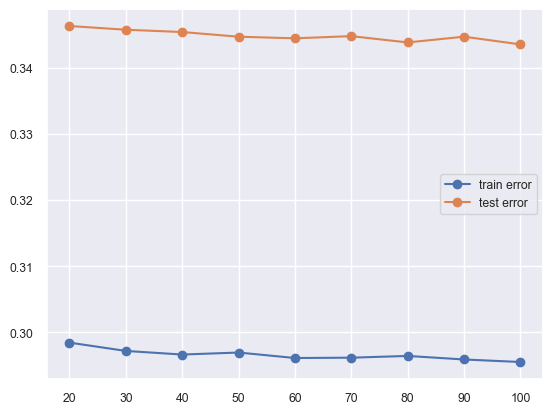

In [69]:
# List of max_depth values to use in RandomForestRegressor
max_depth_list = [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
train_error = []
test_error = []

# List of n_estimators values to try
N_estimator = [20, 30, 40, 50, 60, 70, 80, 90, 100]

# Loop through each n_estimators value
for n in N_estimator:
    # Initialize a RandomForestRegressor with the specified max_depth and n_estimators
    decisiontree = RandomForestRegressor(n_estimators=n, max_depth=12, min_samples_split=2)

    # Fit the model to the scaled training data
    decisiontree.fit(X_train_scaled, y_train)

    # Calculate and store the mean absolute error on the training set
    train_error.append(mean_absolute_error(y_train, decisiontree.predict(X_train_scaled)))

    # Calculate and store the mean absolute error on the test set
    test_error.append(mean_absolute_error(y_test, decisiontree.predict(X_test_scaled)))

plt.plot(N_estimator, train_error, marker='o', label='train error')
plt.plot(N_estimator, test_error, marker='o', label='test error')
plt.legend()

In [70]:
# Create a DataFrame to display feature importances
feature_importance_df = pd.DataFrame({
    'feature': X_train_scaled.columns,
    'importance': randomf.feature_importances_ * 100
})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

# Display the sorted DataFrame
feature_importance_df

feature  importance
4                        room_type   25.692165
3                        longitude   16.623142
2                         latitude   13.718601
5                   minimum_nights   13.044822
9                 availability_365    7.960195
8   calculated_host_listings_count    7.640973
7                reviews_per_month    5.588789
6                number_of_reviews    3.824134
1                    neighbourhood    3.270227
10           number_of_reviews_ltm    2.300203
0              neighbourhood_group    0.336749

### Lasso Regression

In [71]:
#Find the Alpha and report best test performance for Ridge/Lasso.
def Regularization_fit_alpha(model, X_train, y_train, X_valid, y_valid, alphas, Graph=False, logl=False):
    #model = 1-Ridge, 2-Lasso
    #alphas: a list of alpha values to try
    #Graph: plot the graph of R^2 values for different alpha

    R_2_OS = []  #out of sample R2's
    #initialize the model to use for each given alpha
    if model == 1:
        RM = lambda a: linear_model.Ridge(fit_intercept=True, alpha=a)
        model_label = 'Ridge'
    else:
        RM = lambda a: linear_model.Lasso(fit_intercept=True, alpha=a)
        model_label = 'Lasso'

    best_R2 = -1
    best_alpha = alphas[0]
    best_coefs = []

    for a in alphas:  #for all alphas to try
        lm = RM(a)  #assign the model
        lm.fit(X_train, y_train)  #fit the regularization model

        # compute the prediction for the validation sample
        y_predict = lm.predict(X_valid)
        R_2_OS_ = r2_score(y_valid, y_predict)
        R_2_OS.append(R_2_OS_)

        # if current OS R2 is the best - update the best solution
        if R_2_OS_ > best_R2:
            best_R2 = R_2_OS_
            best_alpha = a
            best_coefs = lm.coef_

    # visualization of the performance depending on alpha
    if Graph == True:
        plt.title('OS-R-squared for different Alpha')
        if logl:  #log-scale
            plt.xlabel('ln(Alpha)')
            l = np.log(alphas)
            bl = np.log(best_alpha)
        else:
            plt.xlabel('Alpha')
            l = alphas
            bl = best_alpha
        plt.ylim((-0.1, 1))
        plt.plot(l, R_2_OS, 'b', label=model_label)
        plt.legend(loc='upper right')
        plt.ylabel('R-squared')
        plt.axvline(bl, color='r', linestyle='--')
        plt.show()

    return [best_alpha, best_R2, best_coefs]

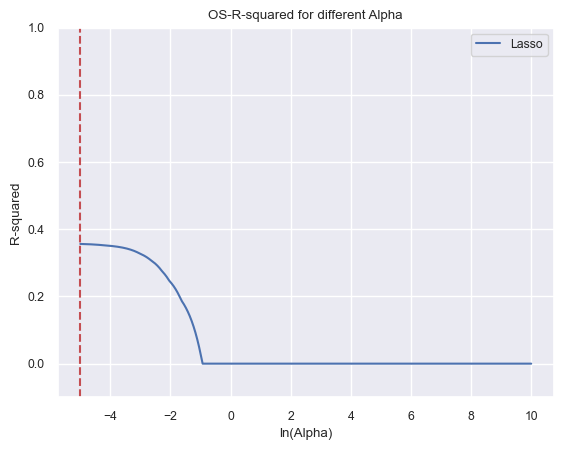

Optimal alpha for Lasso=0.006737946999085467, best OS R_2=0.3562960829330495


In [72]:
#exponential range of possible alphas
alphas_scaled = np.exp(np.linspace(-5, 10, 10000))
[alpha_optimal, best_R2, best_coefs] = Regularization_fit_alpha(
    2,  # Presumably representing L2 regularization
    X_train_scaled.iloc[:, 1:],  # Scaled training features
    y_train,  # Target variable for training
    X_valid_scaled.iloc[:, 1:],  # Scaled validation features
    y_valid,  # Target variable for validation
    alphas_scaled,  # Array of alpha values to test
    Graph=True,  # Indicates whether graphs are generated
    logl=True  # Indicates whether results are logged
)
print('Optimal alpha for Lasso={0}, best OS R_2={1}'.format(alpha_optimal, best_R2))

In [73]:
# Create a Lasso regression model with the optimal alpha value
Lasso = linear_model.Lasso(fit_intercept=True, alpha=alpha_optimal)

# Fit the Lasso model to the scaled training data
Lasso.fit(X_train_scaled.iloc[:, 1:], y_train)

# In sample:
YPred_IS_Lasso = Lasso.predict(X_train_scaled.iloc[:, 1:])
print("The IS R-squared of Lasso is: {0}".format(r2_score(y_train, YPred_IS_Lasso)))

#Out of sample
YPred_OS_Lasso = Lasso.predict(X_test_scaled.iloc[:, 1:])
print("The OS R-squared of Lasso is: {0}".format(r2_score(y_test, YPred_OS_Lasso)))
Lasso.coef_

The IS R-squared of Lasso is: 0.34751293524508
The OS R-squared of Lasso is: 0.3664536243896698


array([ 0.04775716,  0.03905506, -0.178956  , -0.34742655, -0.08574584,
       -0.02228774,  0.05503434, -0.01187077,  0.12331564,  0.        ])

0.463347261572879 0.626918600449211


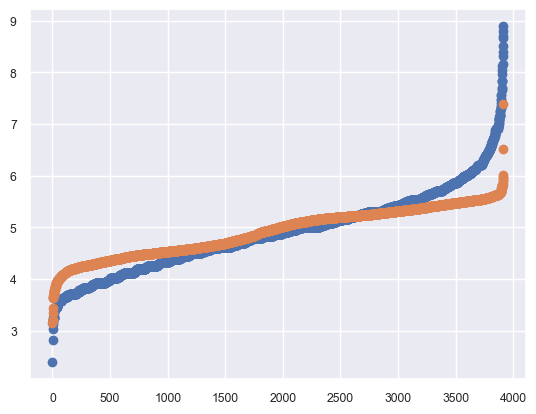

In [74]:
print(mean_absolute_error(y_test, YPred_OS_Lasso), mean_squared_error(y_test, YPred_OS_Lasso) ** 0.5)

plt.scatter(np.arange(len(np.sort(y_test))), np.sort(y_test))
plt.scatter(np.arange(len(np.sort(YPred_OS_Lasso))), np.sort(YPred_OS_Lasso))

### Ridge Regression

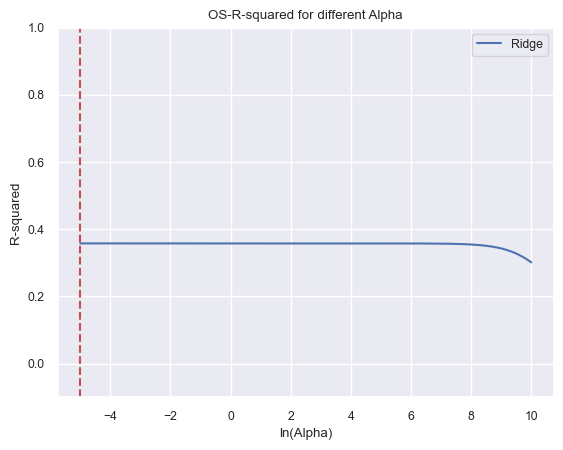

Optimal alpha for Ridge=0.006737946999085467, best OS R_2=0.3578863841420269


In [75]:
#exponential range of possible alphas
alphas_scaled = np.exp(np.linspace(-5, 10, 10000))

[alpha_optimal, best_R2, best_coefs] = Regularization_fit_alpha(
    1,  # Represents L2 regularization (Ridge)
    X_train_scaled.iloc[:, 1:],  # Scaled training features
    y_train,  # Target variable for training
    X_valid_scaled.iloc[:, 1:],  # Scaled validation features
    y_valid,  # Target variable for validation
    alphas_scaled,  # Array of alpha values to test
    Graph=True,  # Indicates whether graphs are generated
    logl=True  # Indicates whether results are logged
)

print('Optimal alpha for Ridge={0}, best OS R_2={1}'.format(alpha_optimal, best_R2))

In [76]:
Ridge = linear_model.Ridge(fit_intercept=True, alpha=alpha_optimal)

# Fit the Ridge model to the scaled training data
Ridge.fit(X_train_scaled.iloc[:, 1:], y_train)

# In sample:
YPred_IS_Ridge = Ridge.predict(X_train_scaled.iloc[:, 1:])
print("The IS R-squared of Ridge is: {0}".format(r2_score(y_train, YPred_IS_Ridge)))

#Out of sample
YPred_OS_Ridge = Ridge.predict(X_test_scaled.iloc[:, 1:])
print("The OS R-squared of Ridge is: {0}".format(r2_score(y_test, YPred_OS_Ridge)))
Ridge.coef_

The IS R-squared of Ridge is: 0.348429559772669
The OS R-squared of Ridge is: 0.3654213562744376


array([ 0.05238257,  0.04551362, -0.18744879, -0.35187179, -0.0907348 ,
       -0.04247073,  0.07880472, -0.01980528,  0.13017685, -0.00548218])

0.46283248426239826 0.6274291271557146


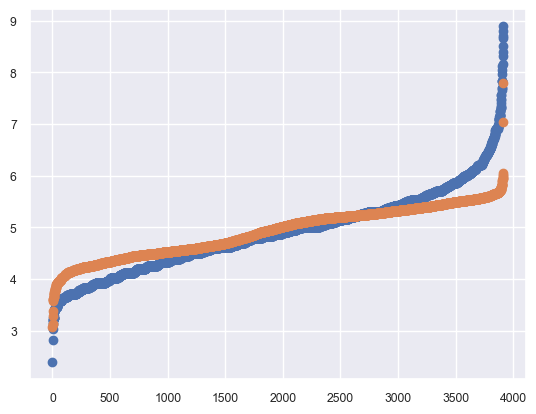

In [77]:
print(mean_absolute_error(y_test, YPred_OS_Ridge), mean_squared_error(y_test, YPred_OS_Ridge) ** 0.5)

plt.scatter(np.arange(len(np.sort(y_test))), np.sort(y_test))
plt.scatter(np.arange(len(np.sort(YPred_OS_Ridge))), np.sort(YPred_OS_Ridge))

### XGBoost Regression

In [78]:
# Define an XGBoost regression model with specified hyperparameters
reg_mod = xgb.XGBRegressor(
    n_estimators=1000,  # Number of boosting rounds (trees)
    learning_rate=0.08,  # Learning rate for each boosting step
    subsample=0.75,  # Fraction of samples used for training each tree
    colsample_bytree=1,  # Fraction of features used for training each tree
    max_depth=7,  # Maximum depth of each decision tree
    gamma=0,  # Regularization parameter for tree complexity
)

In [79]:
# Fit (train) the XGBoost regression model using the training data and evaluation sets
eval_set = [(X_train_scaled, y_train), (X_test_scaled, y_test)]
reg_mod.fit(X_train_scaled, y_train, eval_set=eval_set, eval_metric='rmse', verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.08, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

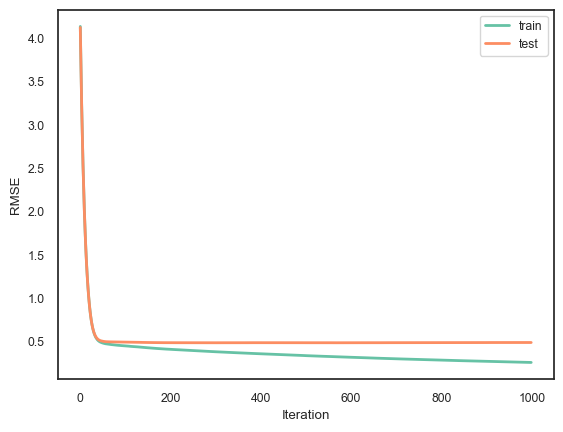

In [80]:
sns.set_style("white")
palette = sns.color_palette("Set2", n_colors=2)

plt.plot(reg_mod.evals_result()['validation_0']['rmse'], label='train', color=palette[0], linewidth=2)
plt.plot(reg_mod.evals_result()['validation_1']['rmse'], label='test', color=palette[1], linewidth=2)
plt.xlabel('Iteration')
plt.ylabel('RMSE')
plt.legend()
plt.savefig('Loss.png')

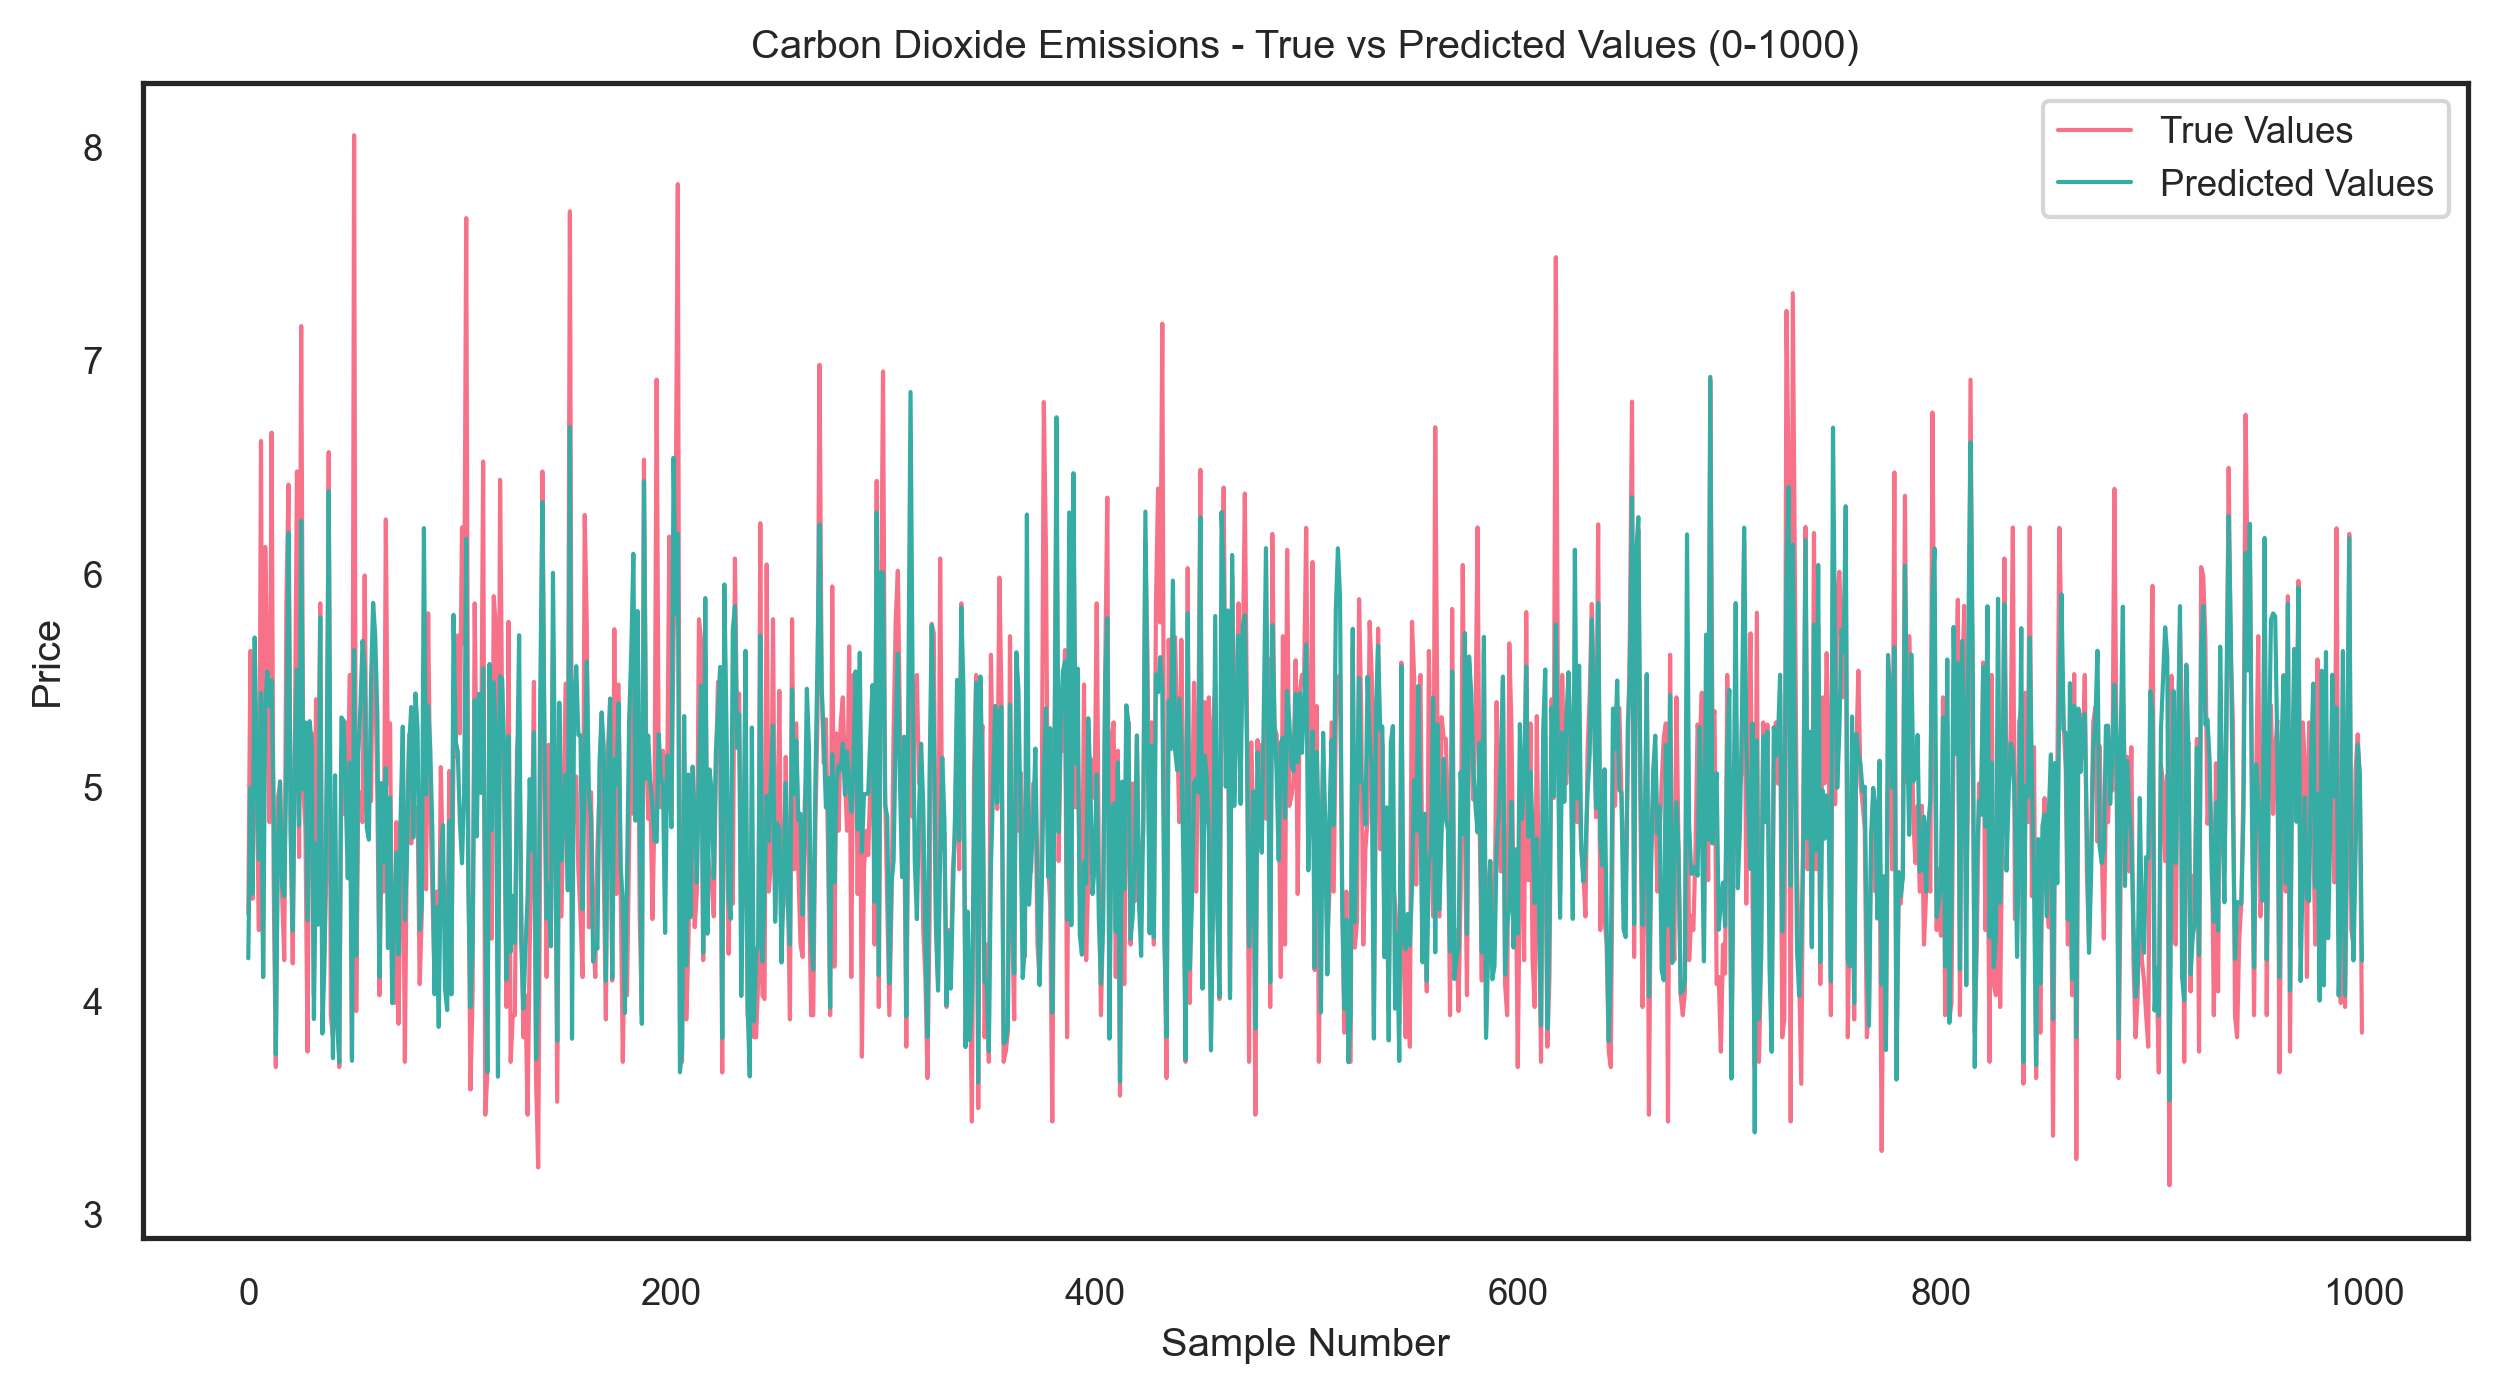

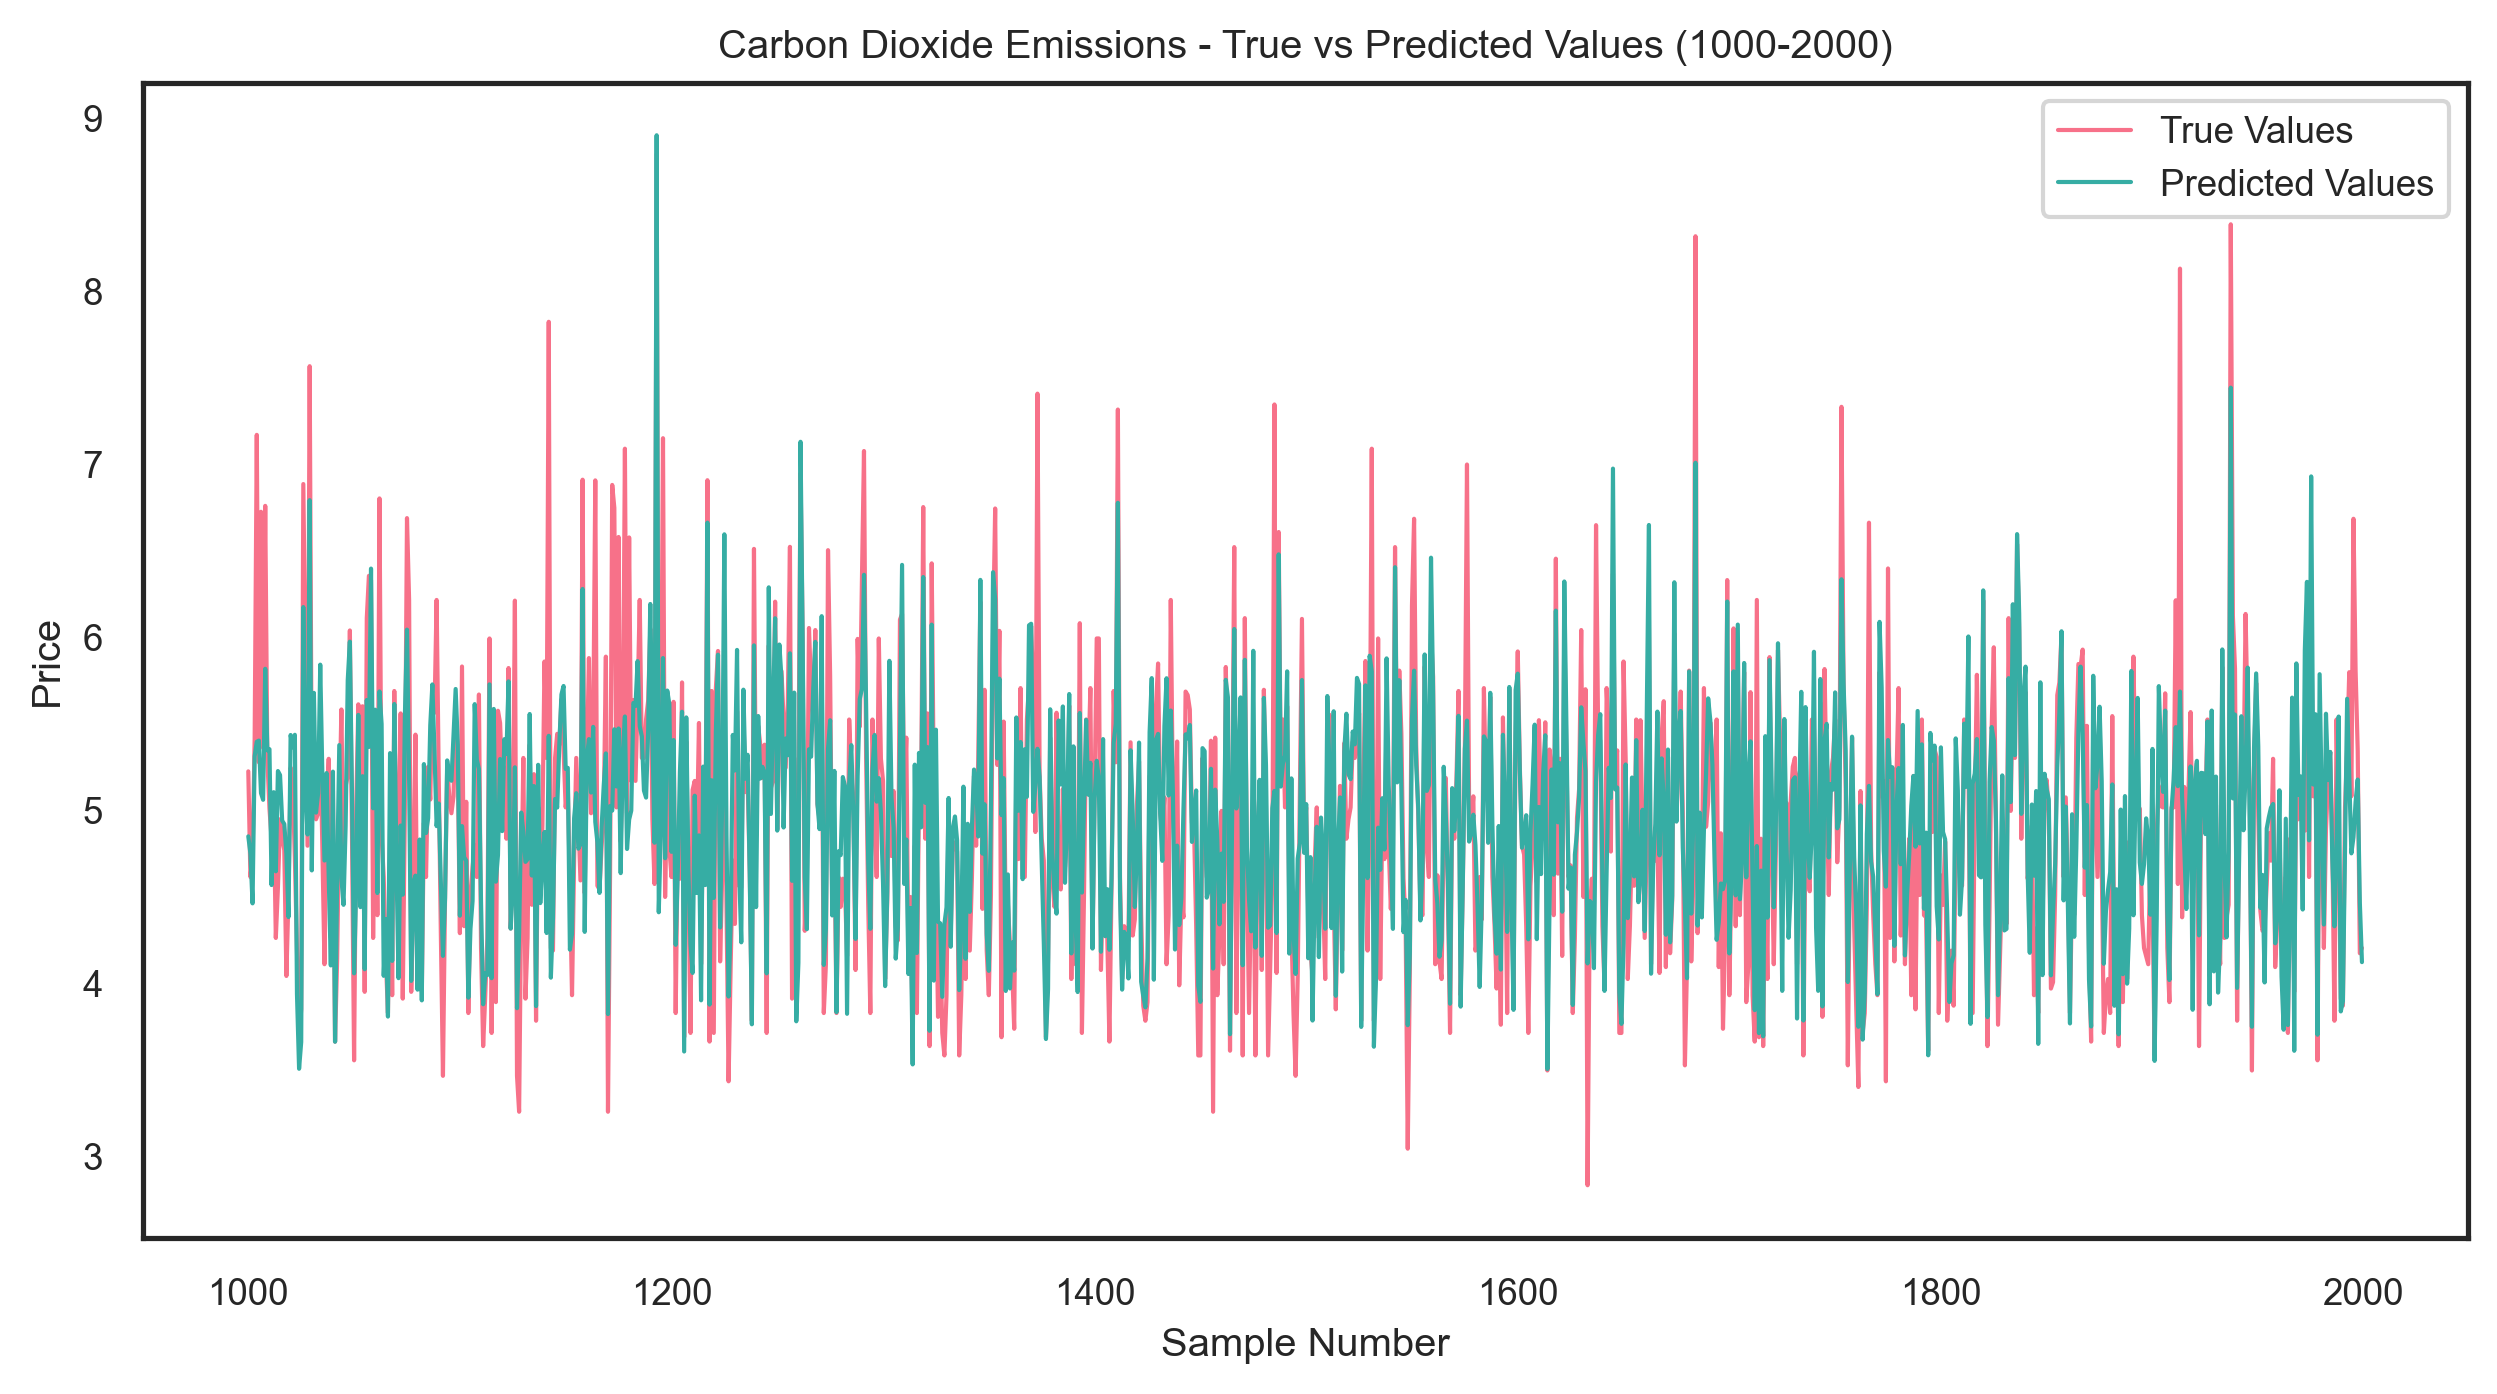

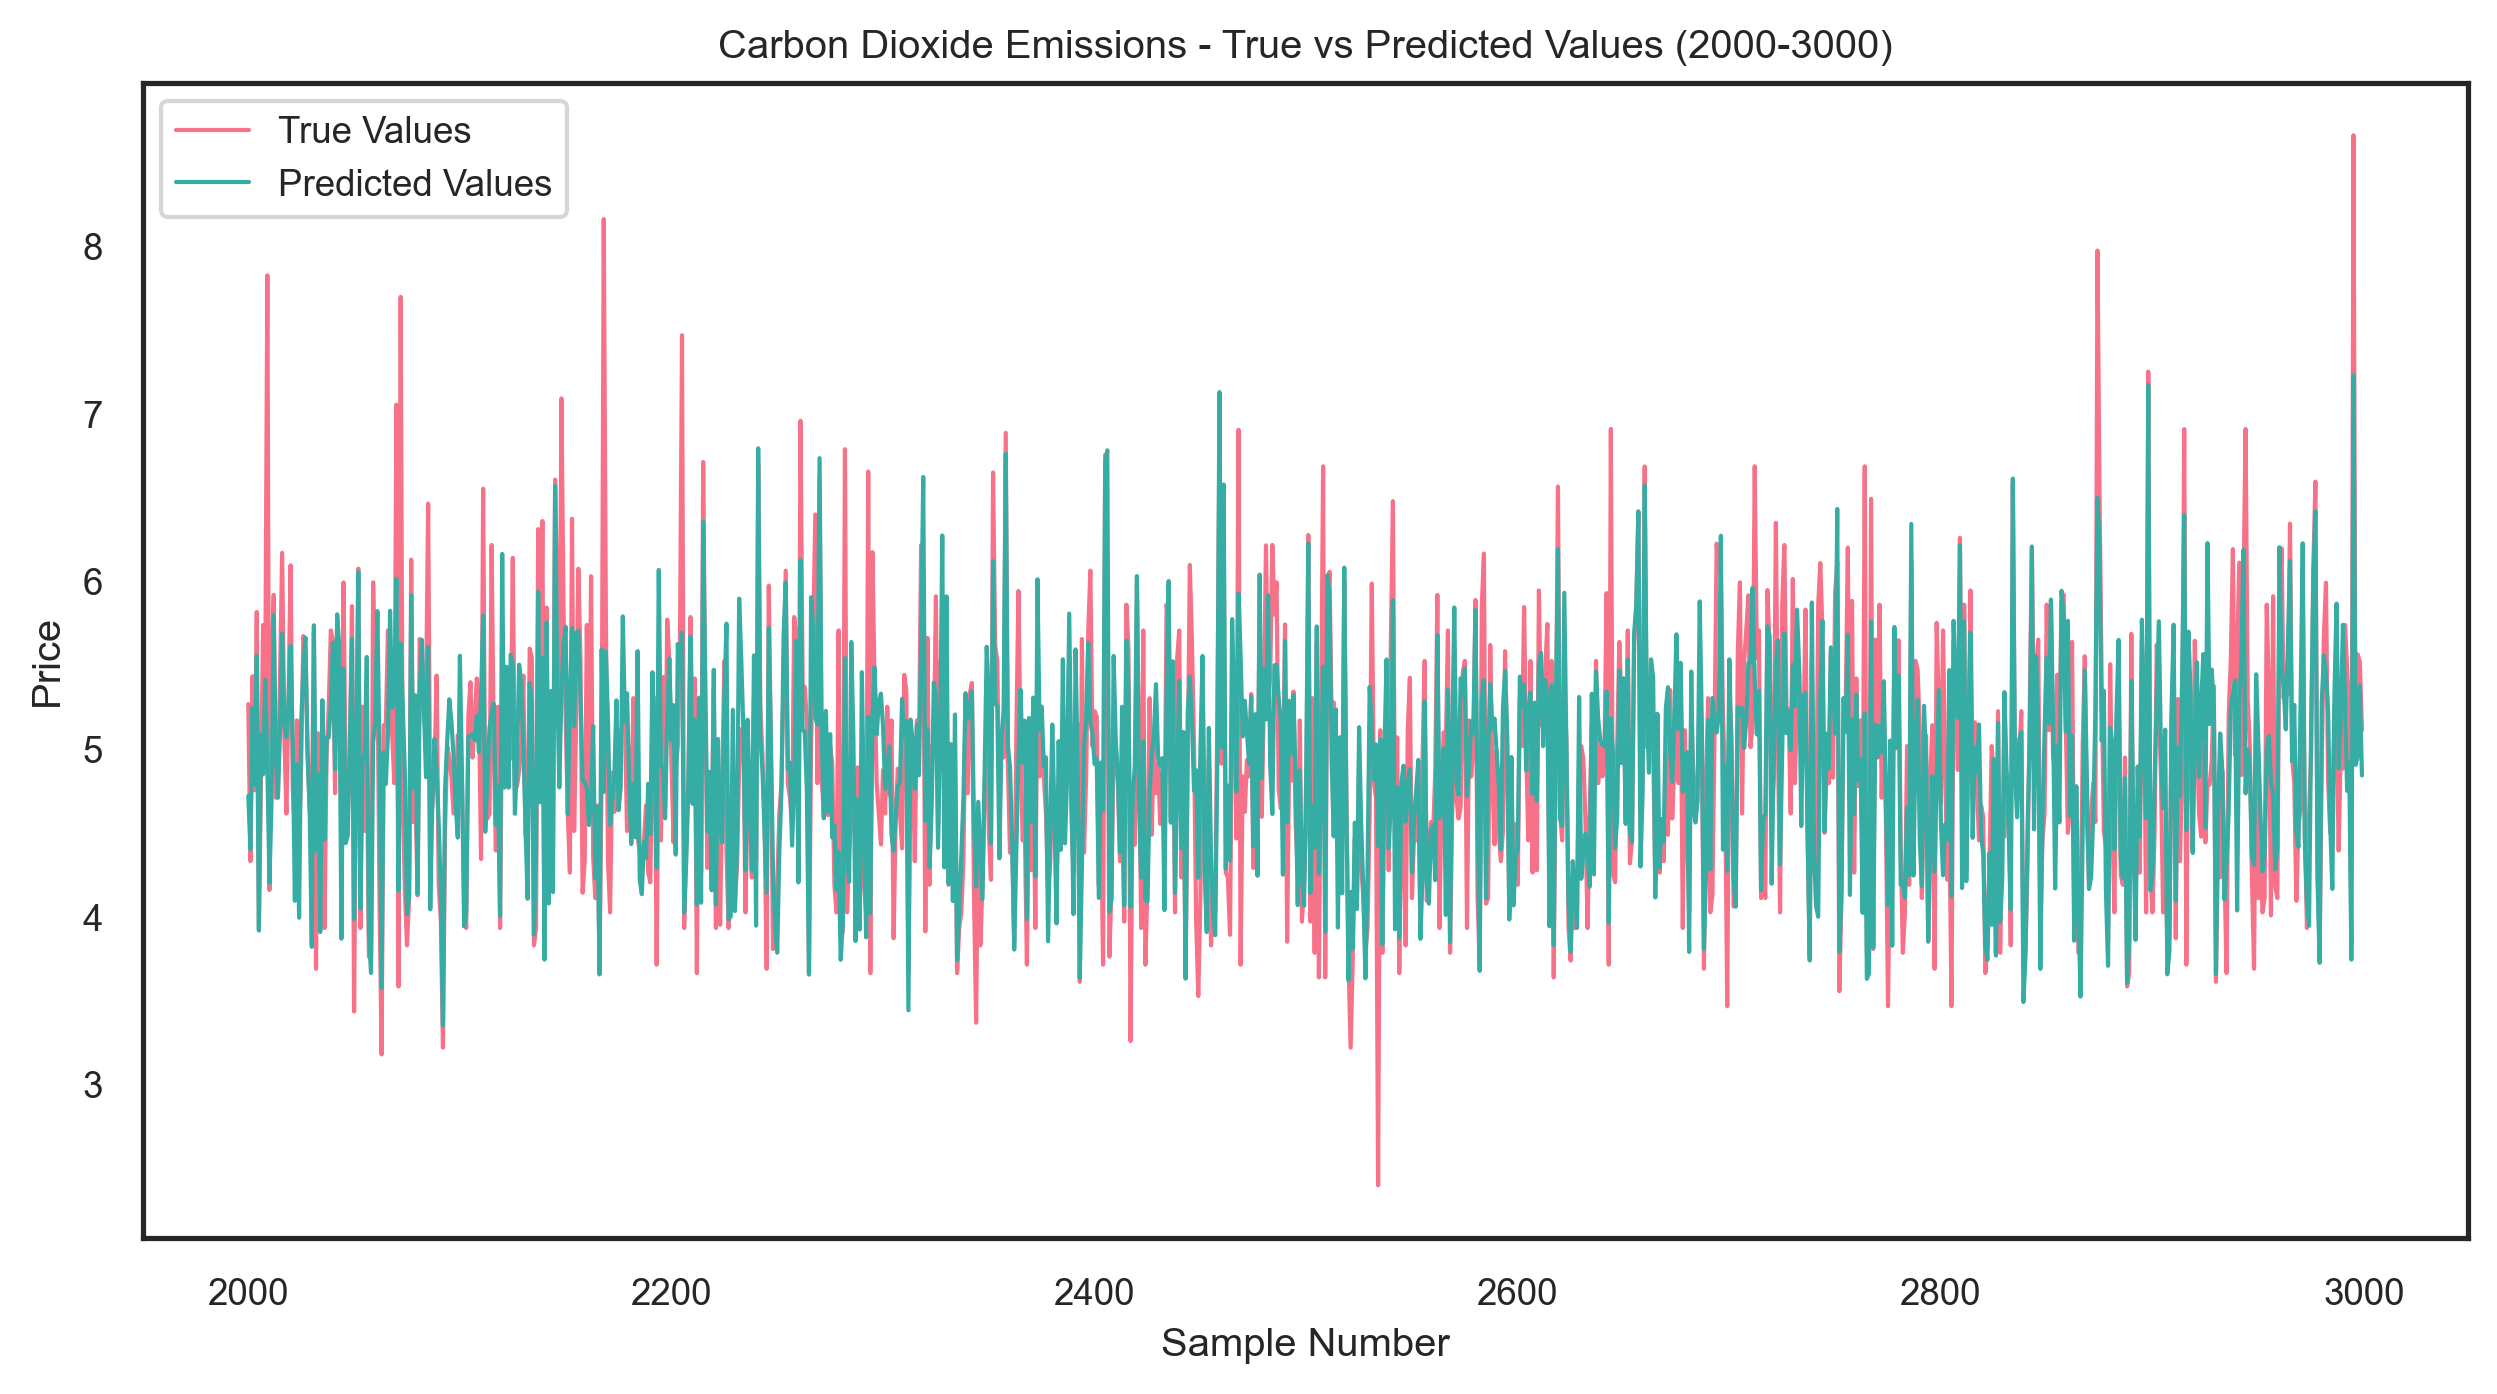

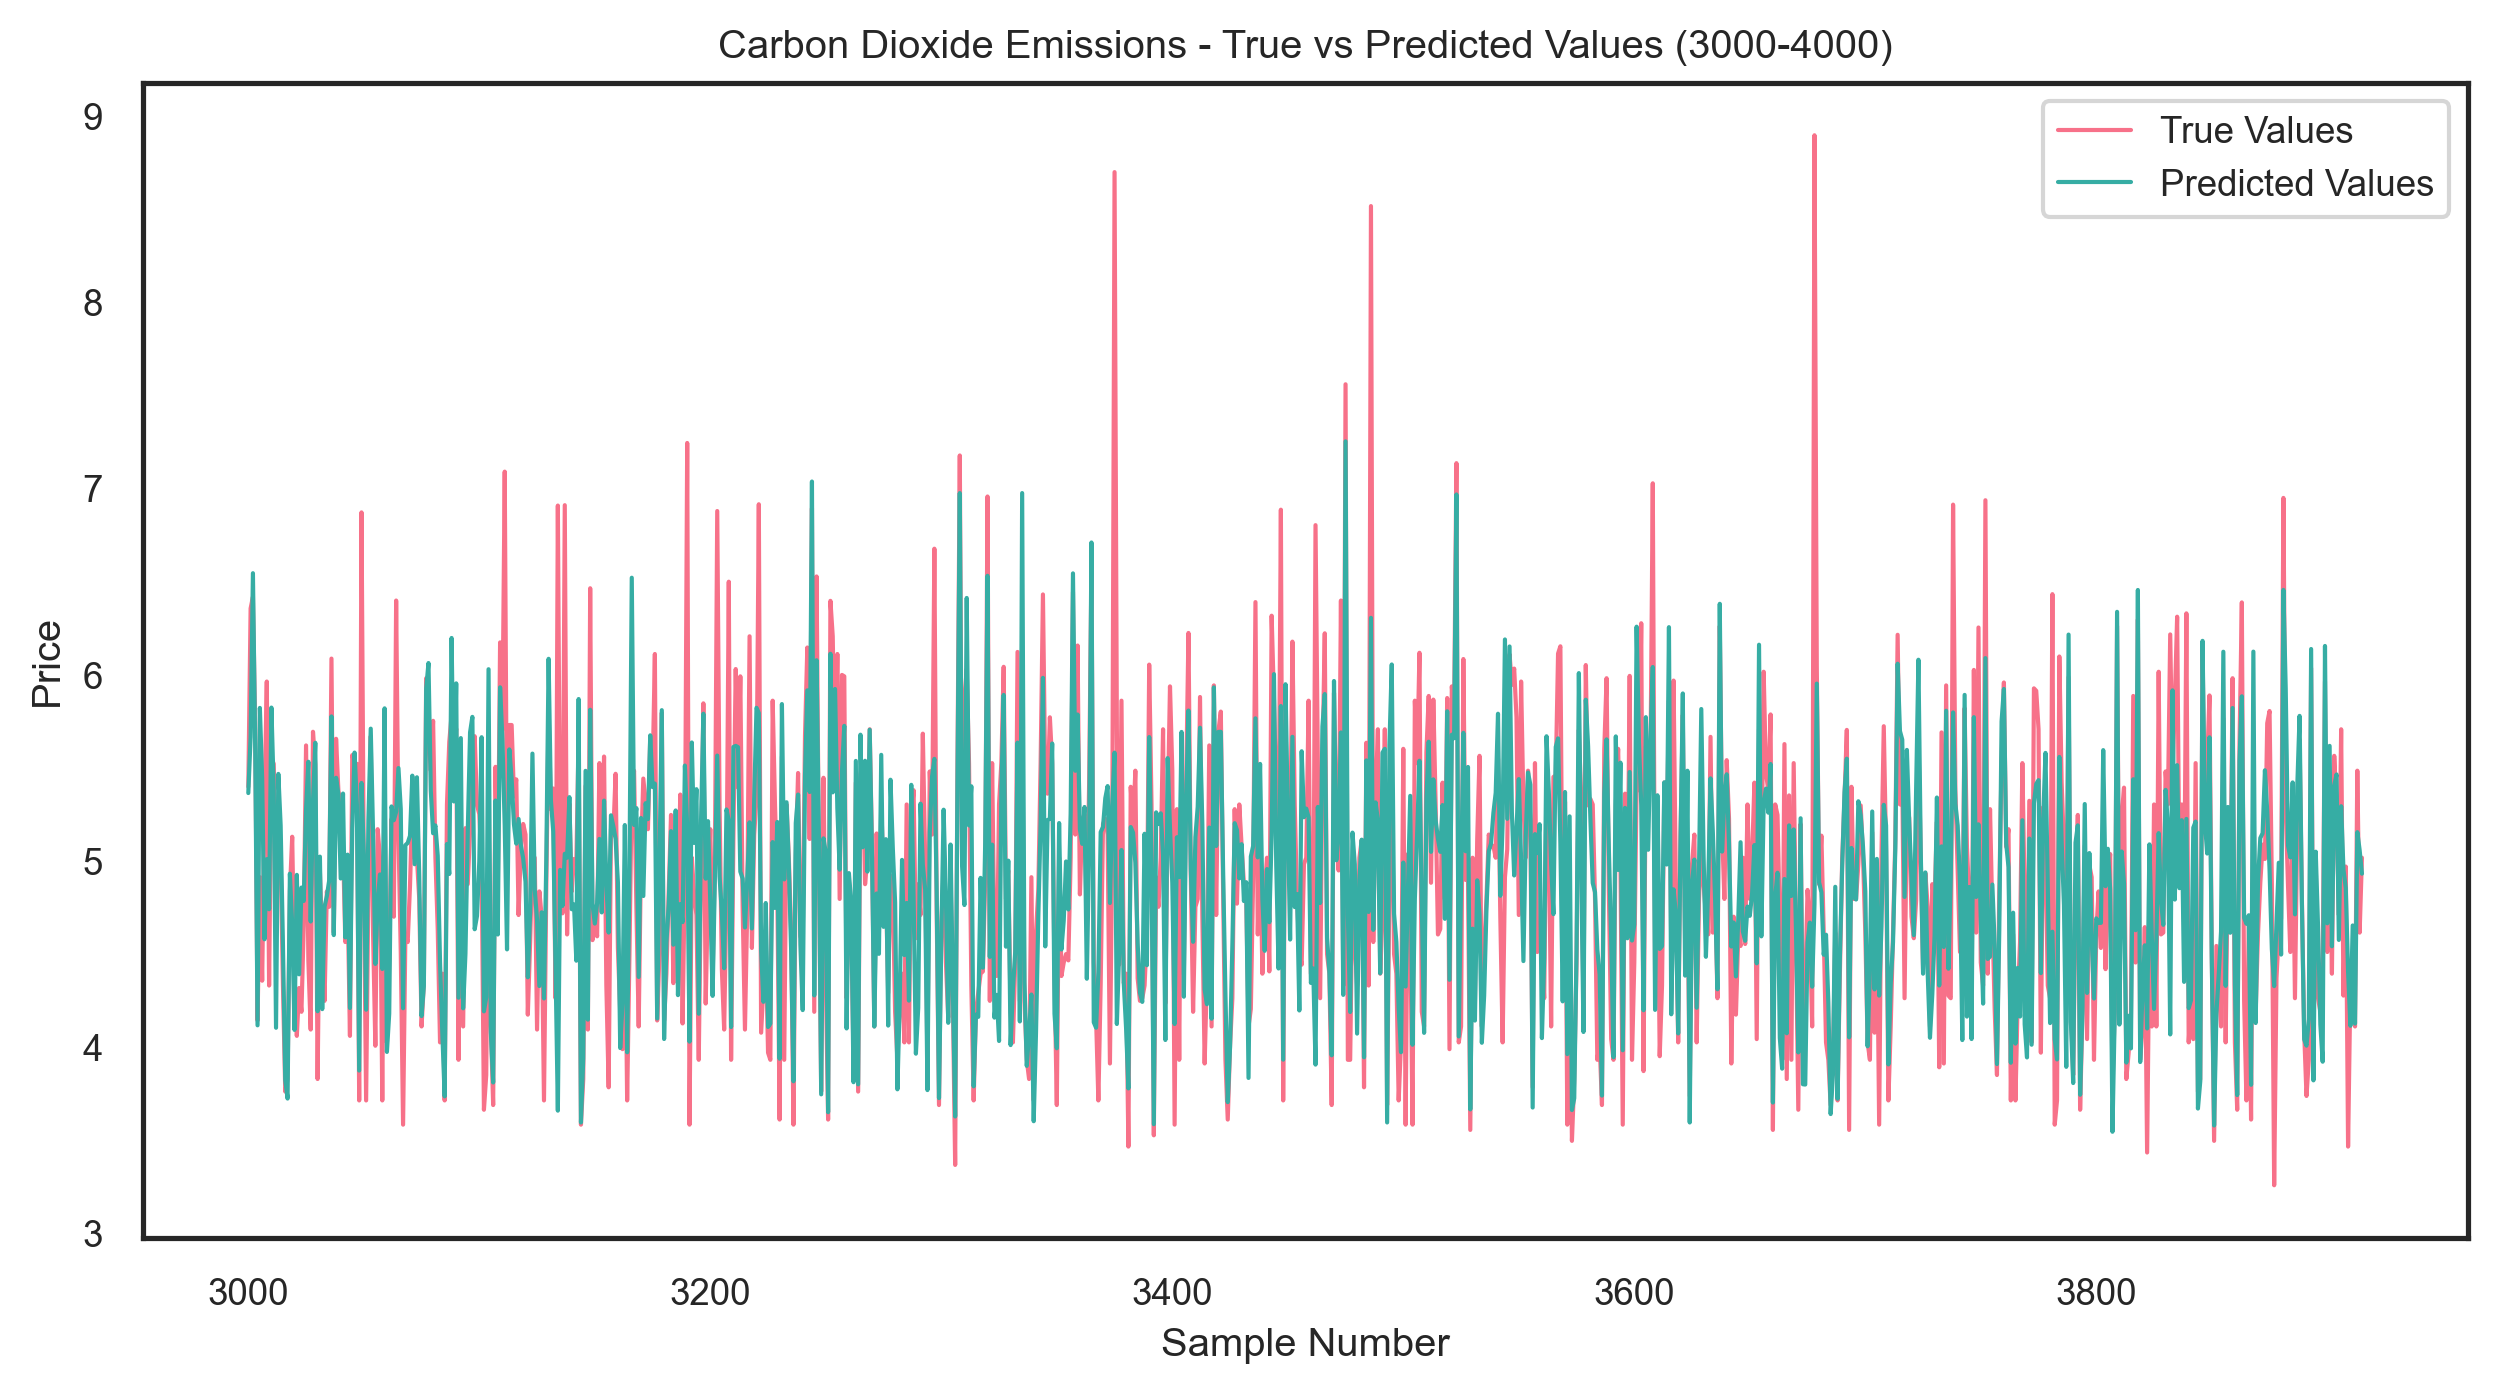

In [81]:
# Predict the target variable using the trained XGBoost regression model
predictions = reg_mod.predict(X_test_scaled)

sns.set_style("white")
palette = sns.color_palette("husl", n_colors=2)

# Define segments to split the data for visualization
segments = [(0, 1000), (1000, 2000), (2000, 3000), (3000, 4000)]

# Iterate through the segments and create separate plots for each segment
for start, end in segments:
    plt.figure(figsize=(10, 5), dpi=300)
    x_ax = range(start, min(end, len(y_test)))

    plt.plot(x_ax, y_test[start:end], label="True Values", color=palette[0], linewidth=1)
    plt.plot(x_ax, predictions[start:end], label="Predicted Values", color=palette[1], linewidth=1)

    plt.title(f"Carbon Dioxide Emissions - True vs Predicted Values ({start}-{end})")
    plt.xlabel("Sample Number")
    plt.ylabel("Price")
    plt.legend()

    plt.savefig(f'True vs Predicted Values_{start}_{end}.png')

    plt.show()